In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 1,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3857408, 828)
(3857408, 8)
validation
(519808, 828)
(519808, 8)
test
(526016, 828)
(526016, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/386 [..............................] - ETA: 11:05 - loss: 2.2131 - STD: 0.0564 - MAE: 0.2187

  3/386 [..............................] - ETA: 10s - loss: 2.1352 - STD: 0.0322 - MAE: 0.2188  

  6/386 [..............................] - ETA: 9s - loss: 2.1224 - STD: 0.0326 - MAE: 0.2187 

  9/386 [..............................] - ETA: 9s - loss: 2.1096 - STD: 0.0262 - MAE: 0.2187

 12/386 [..............................] - ETA: 8s - loss: 2.1028 - STD: 0.0230 - MAE: 0.2187

 15/386 [>.............................] - ETA: 8s - loss: 2.0987 - STD: 0.0217 - MAE: 0.2187

 18/386 [>.............................] - ETA: 8s - loss: 2.0938 - STD: 0.0195 - MAE: 0.2186

 21/386 [>.............................] - ETA: 8s - loss: 2.0890 - STD: 0.0179 - MAE: 0.2185

 24/386 [>.............................] - ETA: 8s - loss: 2.0833 - STD: 0.0173 - MAE: 0.2184

 27/386 [=>............................] - ETA: 8s - loss: 2.0753 - STD: 0.0174 - MAE: 0.2182

 30/386 [=>............................] - ETA: 8s - loss: 2.0650 - STD: 0.0186 - MAE: 0.2178

 33/386 [=>............................] - ETA: 8s - loss: 2.0526 - STD: 0.0209 - MAE: 0.2173

 36/386 [=>............................] - ETA: 8s - loss: 2.0392 - STD: 0.0241 - MAE: 0.2166

 39/386 [==>...........................] - ETA: 8s - loss: 2.0249 - STD: 0.0276 - MAE: 0.2159

 42/386 [==>...........................] - ETA: 8s - loss: 2.0104 - STD: 0.0310 - MAE: 0.2151

 45/386 [==>...........................] - ETA: 7s - loss: 1.9943 - STD: 0.0341 - MAE: 0.2143

 48/386 [==>...........................] - ETA: 7s - loss: 1.9770 - STD: 0.0371 - MAE: 0.2134

 51/386 [==>...........................] - ETA: 7s - loss: 1.9594 - STD: 0.0402 - MAE: 0.2125

 54/386 [===>..........................] - ETA: 7s - loss: 1.9414 - STD: 0.0434 - MAE: 0.2114

 57/386 [===>..........................] - ETA: 7s - loss: 1.9238 - STD: 0.0469 - MAE: 0.2104

 60/386 [===>..........................] - ETA: 7s - loss: 1.9071 - STD: 0.0504 - MAE: 0.2093

 63/386 [===>..........................] - ETA: 7s - loss: 1.8913 - STD: 0.0538 - MAE: 0.2082

 66/386 [====>.........................] - ETA: 7s - loss: 1.8758 - STD: 0.0570 - MAE: 0.2072

 69/386 [====>.........................] - ETA: 7s - loss: 1.8615 - STD: 0.0600 - MAE: 0.2062

 72/386 [====>.........................] - ETA: 7s - loss: 1.8474 - STD: 0.0628 - MAE: 0.2052

 75/386 [====>.........................] - ETA: 7s - loss: 1.8341 - STD: 0.0654 - MAE: 0.2043

 78/386 [=====>........................] - ETA: 7s - loss: 1.8215 - STD: 0.0680 - MAE: 0.2034

 81/386 [=====>........................] - ETA: 7s - loss: 1.8095 - STD: 0.0704 - MAE: 0.2026

 84/386 [=====>........................] - ETA: 7s - loss: 1.7980 - STD: 0.0727 - MAE: 0.2018

 87/386 [=====>........................] - ETA: 6s - loss: 1.7869 - STD: 0.0749 - MAE: 0.2010

 90/386 [=====>........................] - ETA: 6s - loss: 1.7764 - STD: 0.0770 - MAE: 0.2003

 93/386 [======>.......................] - ETA: 6s - loss: 1.7665 - STD: 0.0789 - MAE: 0.1996

 96/386 [======>.......................] - ETA: 6s - loss: 1.7565 - STD: 0.0808 - MAE: 0.1989

 99/386 [======>.......................] - ETA: 6s - loss: 1.7469 - STD: 0.0827 - MAE: 0.1982

102/386 [======>.......................] - ETA: 6s - loss: 1.7381 - STD: 0.0844 - MAE: 0.1975

105/386 [=======>......................] - ETA: 6s - loss: 1.7291 - STD: 0.0861 - MAE: 0.1969

108/386 [=======>......................] - ETA: 6s - loss: 1.7208 - STD: 0.0877 - MAE: 0.1962

111/386 [=======>......................] - ETA: 6s - loss: 1.7126 - STD: 0.0893 - MAE: 0.1956

114/386 [=======>......................] - ETA: 6s - loss: 1.7046 - STD: 0.0907 - MAE: 0.1951

117/386 [========>.....................] - ETA: 6s - loss: 1.6971 - STD: 0.0922 - MAE: 0.1945

120/386 [========>.....................] - ETA: 6s - loss: 1.6896 - STD: 0.0936 - MAE: 0.1939

123/386 [========>.....................] - ETA: 6s - loss: 1.6821 - STD: 0.0950 - MAE: 0.1934

126/386 [========>.....................] - ETA: 6s - loss: 1.6750 - STD: 0.0963 - MAE: 0.1928

129/386 [=========>....................] - ETA: 5s - loss: 1.6681 - STD: 0.0976 - MAE: 0.1923

132/386 [=========>....................] - ETA: 5s - loss: 1.6615 - STD: 0.0989 - MAE: 0.1918

135/386 [=========>....................] - ETA: 5s - loss: 1.6552 - STD: 0.1001 - MAE: 0.1913

138/386 [=========>....................] - ETA: 5s - loss: 1.6491 - STD: 0.1013 - MAE: 0.1908

141/386 [=========>....................] - ETA: 5s - loss: 1.6431 - STD: 0.1024 - MAE: 0.1904

144/386 [==========>...................] - ETA: 5s - loss: 1.6373 - STD: 0.1035 - MAE: 0.1899

147/386 [==========>...................] - ETA: 5s - loss: 1.6316 - STD: 0.1045 - MAE: 0.1895

150/386 [==========>...................] - ETA: 5s - loss: 1.6259 - STD: 0.1056 - MAE: 0.1890

153/386 [==========>...................] - ETA: 5s - loss: 1.6202 - STD: 0.1066 - MAE: 0.1886

156/386 [===========>..................] - ETA: 5s - loss: 1.6147 - STD: 0.1076 - MAE: 0.1881

159/386 [===========>..................] - ETA: 5s - loss: 1.6095 - STD: 0.1086 - MAE: 0.1877

162/386 [===========>..................] - ETA: 5s - loss: 1.6045 - STD: 0.1095 - MAE: 0.1873

165/386 [===========>..................] - ETA: 5s - loss: 1.5997 - STD: 0.1104 - MAE: 0.1869

168/386 [============>.................] - ETA: 5s - loss: 1.5950 - STD: 0.1113 - MAE: 0.1865

171/386 [============>.................] - ETA: 4s - loss: 1.5903 - STD: 0.1122 - MAE: 0.1862

174/386 [============>.................] - ETA: 4s - loss: 1.5859 - STD: 0.1130 - MAE: 0.1858

177/386 [============>.................] - ETA: 4s - loss: 1.5815 - STD: 0.1138 - MAE: 0.1854

180/386 [============>.................] - ETA: 4s - loss: 1.5770 - STD: 0.1146 - MAE: 0.1851

183/386 [=============>................] - ETA: 4s - loss: 1.5726 - STD: 0.1154 - MAE: 0.1847

186/386 [=============>................] - ETA: 4s - loss: 1.5684 - STD: 0.1162 - MAE: 0.1844

189/386 [=============>................] - ETA: 4s - loss: 1.5644 - STD: 0.1169 - MAE: 0.1841

192/386 [=============>................] - ETA: 4s - loss: 1.5604 - STD: 0.1177 - MAE: 0.1837

195/386 [==============>...............] - ETA: 4s - loss: 1.5565 - STD: 0.1184 - MAE: 0.1834

198/386 [==============>...............] - ETA: 4s - loss: 1.5526 - STD: 0.1191 - MAE: 0.1831

201/386 [==============>...............] - ETA: 4s - loss: 1.5490 - STD: 0.1198 - MAE: 0.1828

204/386 [==============>...............] - ETA: 4s - loss: 1.5456 - STD: 0.1205 - MAE: 0.1825

207/386 [===============>..............] - ETA: 4s - loss: 1.5422 - STD: 0.1211 - MAE: 0.1822

210/386 [===============>..............] - ETA: 4s - loss: 1.5388 - STD: 0.1218 - MAE: 0.1819

213/386 [===============>..............] - ETA: 4s - loss: 1.5355 - STD: 0.1224 - MAE: 0.1817

216/386 [===============>..............] - ETA: 3s - loss: 1.5320 - STD: 0.1230 - MAE: 0.1814

219/386 [================>.............] - ETA: 3s - loss: 1.5286 - STD: 0.1236 - MAE: 0.1811

222/386 [================>.............] - ETA: 4s - loss: 1.5256 - STD: 0.1241 - MAE: 0.1808

225/386 [================>.............] - ETA: 4s - loss: 1.5223 - STD: 0.1247 - MAE: 0.1806

228/386 [================>.............] - ETA: 4s - loss: 1.5192 - STD: 0.1253 - MAE: 0.1803

231/386 [================>.............] - ETA: 4s - loss: 1.5161 - STD: 0.1258 - MAE: 0.1801

234/386 [=================>............] - ETA: 4s - loss: 1.5131 - STD: 0.1264 - MAE: 0.1798

237/386 [=================>............] - ETA: 4s - loss: 1.5103 - STD: 0.1269 - MAE: 0.1796

240/386 [=================>............] - ETA: 4s - loss: 1.5074 - STD: 0.1274 - MAE: 0.1793

243/386 [=================>............] - ETA: 3s - loss: 1.5047 - STD: 0.1280 - MAE: 0.1791

246/386 [==================>...........] - ETA: 3s - loss: 1.5021 - STD: 0.1285 - MAE: 0.1789

249/386 [==================>...........] - ETA: 3s - loss: 1.4993 - STD: 0.1290 - MAE: 0.1786

252/386 [==================>...........] - ETA: 3s - loss: 1.4965 - STD: 0.1294 - MAE: 0.1784

255/386 [==================>...........] - ETA: 3s - loss: 1.4938 - STD: 0.1299 - MAE: 0.1782

258/386 [===================>..........] - ETA: 3s - loss: 1.4912 - STD: 0.1304 - MAE: 0.1780

261/386 [===================>..........] - ETA: 3s - loss: 1.4886 - STD: 0.1308 - MAE: 0.1777

264/386 [===================>..........] - ETA: 3s - loss: 1.4859 - STD: 0.1313 - MAE: 0.1775

267/386 [===================>..........] - ETA: 3s - loss: 1.4833 - STD: 0.1317 - MAE: 0.1773

270/386 [===================>..........] - ETA: 3s - loss: 1.4807 - STD: 0.1322 - MAE: 0.1771

273/386 [====================>.........] - ETA: 3s - loss: 1.4782 - STD: 0.1326 - MAE: 0.1769

276/386 [====================>.........] - ETA: 2s - loss: 1.4756 - STD: 0.1330 - MAE: 0.1767

279/386 [====================>.........] - ETA: 2s - loss: 1.4732 - STD: 0.1334 - MAE: 0.1765

282/386 [====================>.........] - ETA: 2s - loss: 1.4707 - STD: 0.1339 - MAE: 0.1763

285/386 [=====================>........] - ETA: 2s - loss: 1.4682 - STD: 0.1343 - MAE: 0.1761

288/386 [=====================>........] - ETA: 2s - loss: 1.4658 - STD: 0.1347 - MAE: 0.1759

291/386 [=====================>........] - ETA: 2s - loss: 1.4635 - STD: 0.1351 - MAE: 0.1757

294/386 [=====================>........] - ETA: 2s - loss: 1.4612 - STD: 0.1355 - MAE: 0.1755

297/386 [======================>.......] - ETA: 2s - loss: 1.4590 - STD: 0.1359 - MAE: 0.1753

300/386 [======================>.......] - ETA: 2s - loss: 1.4569 - STD: 0.1362 - MAE: 0.1751

303/386 [======================>.......] - ETA: 2s - loss: 1.4549 - STD: 0.1366 - MAE: 0.1749

306/386 [======================>.......] - ETA: 2s - loss: 1.4528 - STD: 0.1370 - MAE: 0.1747

309/386 [=======================>......] - ETA: 2s - loss: 1.4510 - STD: 0.1374 - MAE: 0.1746

312/386 [=======================>......] - ETA: 1s - loss: 1.4490 - STD: 0.1377 - MAE: 0.1744

315/386 [=======================>......] - ETA: 1s - loss: 1.4469 - STD: 0.1381 - MAE: 0.1742

318/386 [=======================>......] - ETA: 1s - loss: 1.4450 - STD: 0.1384 - MAE: 0.1741

321/386 [=======================>......] - ETA: 1s - loss: 1.4430 - STD: 0.1388 - MAE: 0.1739

324/386 [========================>.....] - ETA: 1s - loss: 1.4409 - STD: 0.1391 - MAE: 0.1737

327/386 [========================>.....] - ETA: 1s - loss: 1.4388 - STD: 0.1394 - MAE: 0.1736

330/386 [========================>.....] - ETA: 1s - loss: 1.4368 - STD: 0.1397 - MAE: 0.1734

333/386 [========================>.....] - ETA: 1s - loss: 1.4347 - STD: 0.1401 - MAE: 0.1732

336/386 [=========================>....] - ETA: 1s - loss: 1.4328 - STD: 0.1404 - MAE: 0.1731

339/386 [=========================>....] - ETA: 1s - loss: 1.4308 - STD: 0.1407 - MAE: 0.1729

342/386 [=========================>....] - ETA: 1s - loss: 1.4289 - STD: 0.1410 - MAE: 0.1727

345/386 [=========================>....] - ETA: 1s - loss: 1.4271 - STD: 0.1413 - MAE: 0.1726

348/386 [==========================>...] - ETA: 0s - loss: 1.4253 - STD: 0.1417 - MAE: 0.1724

351/386 [==========================>...] - ETA: 0s - loss: 1.4236 - STD: 0.1420 - MAE: 0.1723

354/386 [==========================>...] - ETA: 0s - loss: 1.4217 - STD: 0.1423 - MAE: 0.1721

357/386 [==========================>...] - ETA: 0s - loss: 1.4199 - STD: 0.1426 - MAE: 0.1720

360/386 [==========================>...] - ETA: 0s - loss: 1.4182 - STD: 0.1429 - MAE: 0.1718

363/386 [===========================>..] - ETA: 0s - loss: 1.4164 - STD: 0.1431 - MAE: 0.1717

366/386 [===========================>..] - ETA: 0s - loss: 1.4145 - STD: 0.1434 - MAE: 0.1715

369/386 [===========================>..] - ETA: 0s - loss: 1.4128 - STD: 0.1437 - MAE: 0.1714

372/386 [===========================>..] - ETA: 0s - loss: 1.4111 - STD: 0.1440 - MAE: 0.1712

375/386 [============================>.] - ETA: 0s - loss: 1.4094 - STD: 0.1443 - MAE: 0.1711

378/386 [============================>.] - ETA: 0s - loss: 1.4077 - STD: 0.1446 - MAE: 0.1709

381/386 [============================>.] - ETA: 0s - loss: 1.4061 - STD: 0.1449 - MAE: 0.1708

384/386 [============================>.] - ETA: 0s - loss: 1.4045 - STD: 0.1451 - MAE: 0.1706

386/386 [==============================] - 13s 30ms/step - loss: 1.4034 - STD: 0.1453 - MAE: 0.1705 - val_loss: 1.2688 - val_STD: 0.1730 - val_MAE: 0.1574


Epoch 2/10000


  1/386 [..............................] - ETA: 20s - loss: 1.2035 - STD: 0.1793 - MAE: 0.1532

  4/386 [..............................] - ETA: 8s - loss: 1.1972 - STD: 0.1798 - MAE: 0.1526 

  7/386 [..............................] - ETA: 8s - loss: 1.2307 - STD: 0.1802 - MAE: 0.1541

 10/386 [..............................] - ETA: 8s - loss: 1.2289 - STD: 0.1803 - MAE: 0.1539

 13/386 [>.............................] - ETA: 8s - loss: 1.2243 - STD: 0.1804 - MAE: 0.1537

 16/386 [>.............................] - ETA: 8s - loss: 1.2209 - STD: 0.1803 - MAE: 0.1536

 19/386 [>.............................] - ETA: 8s - loss: 1.2196 - STD: 0.1803 - MAE: 0.1535

 22/386 [>.............................] - ETA: 8s - loss: 1.2162 - STD: 0.1802 - MAE: 0.1533

 25/386 [>.............................] - ETA: 8s - loss: 1.2145 - STD: 0.1803 - MAE: 0.1532

 28/386 [=>............................] - ETA: 8s - loss: 1.2120 - STD: 0.1803 - MAE: 0.1531

 31/386 [=>............................] - ETA: 8s - loss: 1.2097 - STD: 0.1803 - MAE: 0.1530

 34/386 [=>............................] - ETA: 8s - loss: 1.2079 - STD: 0.1802 - MAE: 0.1529

 37/386 [=>............................] - ETA: 8s - loss: 1.2055 - STD: 0.1802 - MAE: 0.1528

 40/386 [==>...........................] - ETA: 7s - loss: 1.2034 - STD: 0.1803 - MAE: 0.1527

 43/386 [==>...........................] - ETA: 7s - loss: 1.2016 - STD: 0.1805 - MAE: 0.1525

 46/386 [==>...........................] - ETA: 7s - loss: 1.2004 - STD: 0.1805 - MAE: 0.1524

 49/386 [==>...........................] - ETA: 7s - loss: 1.1998 - STD: 0.1806 - MAE: 0.1524

 52/386 [===>..........................] - ETA: 7s - loss: 1.1983 - STD: 0.1806 - MAE: 0.1523

 55/386 [===>..........................] - ETA: 7s - loss: 1.1968 - STD: 0.1807 - MAE: 0.1522

 58/386 [===>..........................] - ETA: 7s - loss: 1.1954 - STD: 0.1808 - MAE: 0.1521

 61/386 [===>..........................] - ETA: 7s - loss: 1.1943 - STD: 0.1809 - MAE: 0.1520

 64/386 [===>..........................] - ETA: 7s - loss: 1.1930 - STD: 0.1810 - MAE: 0.1519

 67/386 [====>.........................] - ETA: 7s - loss: 1.1920 - STD: 0.1811 - MAE: 0.1518

 70/386 [====>.........................] - ETA: 7s - loss: 1.1908 - STD: 0.1812 - MAE: 0.1517

 73/386 [====>.........................] - ETA: 7s - loss: 1.1896 - STD: 0.1813 - MAE: 0.1516

 76/386 [====>.........................] - ETA: 7s - loss: 1.1886 - STD: 0.1815 - MAE: 0.1515

 79/386 [=====>........................] - ETA: 7s - loss: 1.1877 - STD: 0.1816 - MAE: 0.1514

 82/386 [=====>........................] - ETA: 7s - loss: 1.1870 - STD: 0.1817 - MAE: 0.1514

 85/386 [=====>........................] - ETA: 6s - loss: 1.1864 - STD: 0.1818 - MAE: 0.1513

 88/386 [=====>........................] - ETA: 6s - loss: 1.1854 - STD: 0.1818 - MAE: 0.1512

 91/386 [======>.......................] - ETA: 6s - loss: 1.1847 - STD: 0.1820 - MAE: 0.1512

 94/386 [======>.......................] - ETA: 6s - loss: 1.1840 - STD: 0.1820 - MAE: 0.1511

 97/386 [======>.......................] - ETA: 6s - loss: 1.1833 - STD: 0.1821 - MAE: 0.1510

100/386 [======>.......................] - ETA: 6s - loss: 1.1831 - STD: 0.1822 - MAE: 0.1510

103/386 [=======>......................] - ETA: 6s - loss: 1.1825 - STD: 0.1823 - MAE: 0.1509

106/386 [=======>......................] - ETA: 6s - loss: 1.1817 - STD: 0.1824 - MAE: 0.1508

109/386 [=======>......................] - ETA: 6s - loss: 1.1810 - STD: 0.1825 - MAE: 0.1508

112/386 [=======>......................] - ETA: 6s - loss: 1.1801 - STD: 0.1826 - MAE: 0.1507

115/386 [=======>......................] - ETA: 6s - loss: 1.1792 - STD: 0.1827 - MAE: 0.1506

118/386 [========>.....................] - ETA: 6s - loss: 1.1786 - STD: 0.1828 - MAE: 0.1506

121/386 [========>.....................] - ETA: 6s - loss: 1.1781 - STD: 0.1829 - MAE: 0.1505

124/386 [========>.....................] - ETA: 6s - loss: 1.1775 - STD: 0.1830 - MAE: 0.1504

127/386 [========>.....................] - ETA: 6s - loss: 1.1770 - STD: 0.1830 - MAE: 0.1504

130/386 [=========>....................] - ETA: 5s - loss: 1.1768 - STD: 0.1831 - MAE: 0.1504

133/386 [=========>....................] - ETA: 5s - loss: 1.1766 - STD: 0.1832 - MAE: 0.1503

136/386 [=========>....................] - ETA: 5s - loss: 1.1766 - STD: 0.1833 - MAE: 0.1503

139/386 [=========>....................] - ETA: 5s - loss: 1.1764 - STD: 0.1834 - MAE: 0.1503

142/386 [==========>...................] - ETA: 5s - loss: 1.1762 - STD: 0.1834 - MAE: 0.1502

145/386 [==========>...................] - ETA: 5s - loss: 1.1757 - STD: 0.1835 - MAE: 0.1502

148/386 [==========>...................] - ETA: 5s - loss: 1.1751 - STD: 0.1836 - MAE: 0.1501

151/386 [==========>...................] - ETA: 5s - loss: 1.1747 - STD: 0.1836 - MAE: 0.1501

154/386 [==========>...................] - ETA: 5s - loss: 1.1742 - STD: 0.1837 - MAE: 0.1500

157/386 [===========>..................] - ETA: 5s - loss: 1.1737 - STD: 0.1837 - MAE: 0.1500

160/386 [===========>..................] - ETA: 5s - loss: 1.1730 - STD: 0.1838 - MAE: 0.1499

163/386 [===========>..................] - ETA: 5s - loss: 1.1721 - STD: 0.1839 - MAE: 0.1498

166/386 [===========>..................] - ETA: 5s - loss: 1.1716 - STD: 0.1840 - MAE: 0.1498

169/386 [============>.................] - ETA: 5s - loss: 1.1708 - STD: 0.1841 - MAE: 0.1497

172/386 [============>.................] - ETA: 4s - loss: 1.1702 - STD: 0.1841 - MAE: 0.1496

175/386 [============>.................] - ETA: 4s - loss: 1.1694 - STD: 0.1842 - MAE: 0.1496

178/386 [============>.................] - ETA: 4s - loss: 1.1687 - STD: 0.1843 - MAE: 0.1495

181/386 [=============>................] - ETA: 4s - loss: 1.1681 - STD: 0.1843 - MAE: 0.1495

184/386 [=============>................] - ETA: 4s - loss: 1.1674 - STD: 0.1844 - MAE: 0.1494

187/386 [=============>................] - ETA: 4s - loss: 1.1668 - STD: 0.1845 - MAE: 0.1493

190/386 [=============>................] - ETA: 4s - loss: 1.1662 - STD: 0.1846 - MAE: 0.1492

193/386 [==============>...............] - ETA: 4s - loss: 1.1656 - STD: 0.1847 - MAE: 0.1492

196/386 [==============>...............] - ETA: 4s - loss: 1.1651 - STD: 0.1848 - MAE: 0.1491

199/386 [==============>...............] - ETA: 4s - loss: 1.1644 - STD: 0.1848 - MAE: 0.1491

202/386 [==============>...............] - ETA: 4s - loss: 1.1640 - STD: 0.1849 - MAE: 0.1490

205/386 [==============>...............] - ETA: 4s - loss: 1.1633 - STD: 0.1850 - MAE: 0.1490

208/386 [===============>..............] - ETA: 4s - loss: 1.1632 - STD: 0.1851 - MAE: 0.1489

211/386 [===============>..............] - ETA: 4s - loss: 1.1628 - STD: 0.1851 - MAE: 0.1489

214/386 [===============>..............] - ETA: 3s - loss: 1.1624 - STD: 0.1852 - MAE: 0.1488

217/386 [===============>..............] - ETA: 3s - loss: 1.1618 - STD: 0.1853 - MAE: 0.1488

220/386 [================>.............] - ETA: 3s - loss: 1.1612 - STD: 0.1854 - MAE: 0.1487

223/386 [================>.............] - ETA: 3s - loss: 1.1606 - STD: 0.1854 - MAE: 0.1487

226/386 [================>.............] - ETA: 3s - loss: 1.1603 - STD: 0.1855 - MAE: 0.1486

229/386 [================>.............] - ETA: 3s - loss: 1.1599 - STD: 0.1856 - MAE: 0.1486

232/386 [=================>............] - ETA: 3s - loss: 1.1595 - STD: 0.1856 - MAE: 0.1485

235/386 [=================>............] - ETA: 3s - loss: 1.1593 - STD: 0.1857 - MAE: 0.1485

238/386 [=================>............] - ETA: 3s - loss: 1.1590 - STD: 0.1858 - MAE: 0.1484

241/386 [=================>............] - ETA: 3s - loss: 1.1586 - STD: 0.1858 - MAE: 0.1484

244/386 [=================>............] - ETA: 3s - loss: 1.1579 - STD: 0.1859 - MAE: 0.1483

247/386 [==================>...........] - ETA: 3s - loss: 1.1575 - STD: 0.1860 - MAE: 0.1483

250/386 [==================>...........] - ETA: 3s - loss: 1.1569 - STD: 0.1860 - MAE: 0.1482

253/386 [==================>...........] - ETA: 3s - loss: 1.1564 - STD: 0.1861 - MAE: 0.1482

256/386 [==================>...........] - ETA: 3s - loss: 1.1558 - STD: 0.1861 - MAE: 0.1481

259/386 [===================>..........] - ETA: 2s - loss: 1.1553 - STD: 0.1862 - MAE: 0.1481

262/386 [===================>..........] - ETA: 2s - loss: 1.1547 - STD: 0.1863 - MAE: 0.1480

265/386 [===================>..........] - ETA: 2s - loss: 1.1543 - STD: 0.1863 - MAE: 0.1480

268/386 [===================>..........] - ETA: 2s - loss: 1.1537 - STD: 0.1864 - MAE: 0.1479

271/386 [====================>.........] - ETA: 2s - loss: 1.1530 - STD: 0.1865 - MAE: 0.1479

274/386 [====================>.........] - ETA: 2s - loss: 1.1526 - STD: 0.1865 - MAE: 0.1478

277/386 [====================>.........] - ETA: 2s - loss: 1.1522 - STD: 0.1866 - MAE: 0.1478

280/386 [====================>.........] - ETA: 2s - loss: 1.1520 - STD: 0.1867 - MAE: 0.1477

283/386 [====================>.........] - ETA: 2s - loss: 1.1515 - STD: 0.1868 - MAE: 0.1477

286/386 [=====================>........] - ETA: 2s - loss: 1.1510 - STD: 0.1868 - MAE: 0.1476

289/386 [=====================>........] - ETA: 2s - loss: 1.1506 - STD: 0.1869 - MAE: 0.1476

292/386 [=====================>........] - ETA: 2s - loss: 1.1501 - STD: 0.1870 - MAE: 0.1475

295/386 [=====================>........] - ETA: 2s - loss: 1.1498 - STD: 0.1870 - MAE: 0.1475

298/386 [======================>.......] - ETA: 2s - loss: 1.1495 - STD: 0.1871 - MAE: 0.1474

301/386 [======================>.......] - ETA: 1s - loss: 1.1492 - STD: 0.1872 - MAE: 0.1474

304/386 [======================>.......] - ETA: 1s - loss: 1.1488 - STD: 0.1872 - MAE: 0.1474

307/386 [======================>.......] - ETA: 1s - loss: 1.1484 - STD: 0.1873 - MAE: 0.1473

310/386 [=======================>......] - ETA: 1s - loss: 1.1481 - STD: 0.1873 - MAE: 0.1473

313/386 [=======================>......] - ETA: 1s - loss: 1.1477 - STD: 0.1874 - MAE: 0.1472

316/386 [=======================>......] - ETA: 1s - loss: 1.1472 - STD: 0.1874 - MAE: 0.1472

319/386 [=======================>......] - ETA: 1s - loss: 1.1468 - STD: 0.1875 - MAE: 0.1472

322/386 [========================>.....] - ETA: 1s - loss: 1.1466 - STD: 0.1875 - MAE: 0.1471

325/386 [========================>.....] - ETA: 1s - loss: 1.1461 - STD: 0.1876 - MAE: 0.1471

328/386 [========================>.....] - ETA: 1s - loss: 1.1456 - STD: 0.1876 - MAE: 0.1470

331/386 [========================>.....] - ETA: 1s - loss: 1.1451 - STD: 0.1877 - MAE: 0.1470

334/386 [========================>.....] - ETA: 1s - loss: 1.1446 - STD: 0.1878 - MAE: 0.1469

337/386 [=========================>....] - ETA: 1s - loss: 1.1442 - STD: 0.1878 - MAE: 0.1469

340/386 [=========================>....] - ETA: 1s - loss: 1.1438 - STD: 0.1879 - MAE: 0.1468

343/386 [=========================>....] - ETA: 0s - loss: 1.1434 - STD: 0.1879 - MAE: 0.1468

346/386 [=========================>....] - ETA: 0s - loss: 1.1430 - STD: 0.1880 - MAE: 0.1467

349/386 [==========================>...] - ETA: 0s - loss: 1.1426 - STD: 0.1881 - MAE: 0.1467

352/386 [==========================>...] - ETA: 0s - loss: 1.1422 - STD: 0.1881 - MAE: 0.1466

355/386 [==========================>...] - ETA: 0s - loss: 1.1417 - STD: 0.1882 - MAE: 0.1466

358/386 [==========================>...] - ETA: 0s - loss: 1.1414 - STD: 0.1883 - MAE: 0.1466

361/386 [===========================>..] - ETA: 0s - loss: 1.1410 - STD: 0.1883 - MAE: 0.1465

364/386 [===========================>..] - ETA: 0s - loss: 1.1407 - STD: 0.1884 - MAE: 0.1465

367/386 [===========================>..] - ETA: 0s - loss: 1.1403 - STD: 0.1884 - MAE: 0.1464

370/386 [===========================>..] - ETA: 0s - loss: 1.1398 - STD: 0.1885 - MAE: 0.1464

373/386 [===========================>..] - ETA: 0s - loss: 1.1394 - STD: 0.1885 - MAE: 0.1464

376/386 [============================>.] - ETA: 0s - loss: 1.1389 - STD: 0.1886 - MAE: 0.1463

379/386 [============================>.] - ETA: 0s - loss: 1.1384 - STD: 0.1887 - MAE: 0.1463

382/386 [============================>.] - ETA: 0s - loss: 1.1380 - STD: 0.1887 - MAE: 0.1462

385/386 [============================>.] - ETA: 0s - loss: 1.1376 - STD: 0.1888 - MAE: 0.1462

386/386 [==============================] - 10s 26ms/step - loss: 1.1374 - STD: 0.1888 - MAE: 0.1461 - val_loss: 1.2190 - val_STD: 0.1892 - val_MAE: 0.1500


Epoch 3/10000


  1/386 [..............................] - ETA: 18s - loss: 1.0921 - STD: 0.1948 - MAE: 0.1411

  4/386 [..............................] - ETA: 9s - loss: 1.0867 - STD: 0.1960 - MAE: 0.1406 

  7/386 [..............................] - ETA: 8s - loss: 1.0822 - STD: 0.1961 - MAE: 0.1404

 10/386 [..............................] - ETA: 8s - loss: 1.0797 - STD: 0.1963 - MAE: 0.1401

 13/386 [>.............................] - ETA: 8s - loss: 1.0792 - STD: 0.1964 - MAE: 0.1401

 16/386 [>.............................] - ETA: 8s - loss: 1.0785 - STD: 0.1964 - MAE: 0.1400

 19/386 [>.............................] - ETA: 8s - loss: 1.0786 - STD: 0.1965 - MAE: 0.1400

 22/386 [>.............................] - ETA: 8s - loss: 1.0821 - STD: 0.1966 - MAE: 0.1402

 25/386 [>.............................] - ETA: 8s - loss: 1.0891 - STD: 0.1968 - MAE: 0.1404

 28/386 [=>............................] - ETA: 8s - loss: 1.0883 - STD: 0.1968 - MAE: 0.1404

 31/386 [=>............................] - ETA: 8s - loss: 1.0894 - STD: 0.1967 - MAE: 0.1405

 34/386 [=>............................] - ETA: 8s - loss: 1.0896 - STD: 0.1967 - MAE: 0.1405

 37/386 [=>............................] - ETA: 8s - loss: 1.0895 - STD: 0.1966 - MAE: 0.1405

 40/386 [==>...........................] - ETA: 8s - loss: 1.0887 - STD: 0.1966 - MAE: 0.1405

 43/386 [==>...........................] - ETA: 8s - loss: 1.0882 - STD: 0.1966 - MAE: 0.1405

 46/386 [==>...........................] - ETA: 7s - loss: 1.0871 - STD: 0.1965 - MAE: 0.1404

 49/386 [==>...........................] - ETA: 7s - loss: 1.0853 - STD: 0.1966 - MAE: 0.1403

 52/386 [===>..........................] - ETA: 7s - loss: 1.0849 - STD: 0.1966 - MAE: 0.1403

 55/386 [===>..........................] - ETA: 7s - loss: 1.0847 - STD: 0.1967 - MAE: 0.1402

 58/386 [===>..........................] - ETA: 7s - loss: 1.0838 - STD: 0.1967 - MAE: 0.1402

 61/386 [===>..........................] - ETA: 7s - loss: 1.0833 - STD: 0.1967 - MAE: 0.1402

 64/386 [===>..........................] - ETA: 7s - loss: 1.0822 - STD: 0.1967 - MAE: 0.1401

 67/386 [====>.........................] - ETA: 7s - loss: 1.0811 - STD: 0.1968 - MAE: 0.1400

 70/386 [====>.........................] - ETA: 7s - loss: 1.0801 - STD: 0.1968 - MAE: 0.1399

 73/386 [====>.........................] - ETA: 7s - loss: 1.0792 - STD: 0.1969 - MAE: 0.1398

 76/386 [====>.........................] - ETA: 7s - loss: 1.0785 - STD: 0.1970 - MAE: 0.1397

 79/386 [=====>........................] - ETA: 7s - loss: 1.0775 - STD: 0.1971 - MAE: 0.1397

 82/386 [=====>........................] - ETA: 7s - loss: 1.0771 - STD: 0.1972 - MAE: 0.1396

 85/386 [=====>........................] - ETA: 7s - loss: 1.0768 - STD: 0.1973 - MAE: 0.1396

 88/386 [=====>........................] - ETA: 6s - loss: 1.0759 - STD: 0.1974 - MAE: 0.1395

 91/386 [======>.......................] - ETA: 6s - loss: 1.0751 - STD: 0.1974 - MAE: 0.1394

 94/386 [======>.......................] - ETA: 6s - loss: 1.0744 - STD: 0.1975 - MAE: 0.1394

 97/386 [======>.......................] - ETA: 6s - loss: 1.0747 - STD: 0.1976 - MAE: 0.1393

100/386 [======>.......................] - ETA: 6s - loss: 1.0753 - STD: 0.1977 - MAE: 0.1393

103/386 [=======>......................] - ETA: 6s - loss: 1.0750 - STD: 0.1977 - MAE: 0.1393

106/386 [=======>......................] - ETA: 6s - loss: 1.0746 - STD: 0.1977 - MAE: 0.1393

109/386 [=======>......................] - ETA: 6s - loss: 1.0748 - STD: 0.1978 - MAE: 0.1393

112/386 [=======>......................] - ETA: 6s - loss: 1.0748 - STD: 0.1978 - MAE: 0.1392

115/386 [=======>......................] - ETA: 6s - loss: 1.0744 - STD: 0.1979 - MAE: 0.1392

118/386 [========>.....................] - ETA: 6s - loss: 1.0745 - STD: 0.1979 - MAE: 0.1392

121/386 [========>.....................] - ETA: 6s - loss: 1.0742 - STD: 0.1980 - MAE: 0.1391

124/386 [========>.....................] - ETA: 6s - loss: 1.0739 - STD: 0.1980 - MAE: 0.1391

127/386 [========>.....................] - ETA: 6s - loss: 1.0737 - STD: 0.1980 - MAE: 0.1391

130/386 [=========>....................] - ETA: 5s - loss: 1.0735 - STD: 0.1981 - MAE: 0.1390

133/386 [=========>....................] - ETA: 5s - loss: 1.0733 - STD: 0.1981 - MAE: 0.1390

136/386 [=========>....................] - ETA: 5s - loss: 1.0730 - STD: 0.1982 - MAE: 0.1390

139/386 [=========>....................] - ETA: 5s - loss: 1.0728 - STD: 0.1982 - MAE: 0.1390

142/386 [==========>...................] - ETA: 5s - loss: 1.0721 - STD: 0.1982 - MAE: 0.1389

145/386 [==========>...................] - ETA: 5s - loss: 1.0716 - STD: 0.1983 - MAE: 0.1389

148/386 [==========>...................] - ETA: 5s - loss: 1.0712 - STD: 0.1983 - MAE: 0.1388

151/386 [==========>...................] - ETA: 5s - loss: 1.0706 - STD: 0.1984 - MAE: 0.1388

154/386 [==========>...................] - ETA: 5s - loss: 1.0702 - STD: 0.1984 - MAE: 0.1387

157/386 [===========>..................] - ETA: 5s - loss: 1.0697 - STD: 0.1985 - MAE: 0.1387

160/386 [===========>..................] - ETA: 5s - loss: 1.0694 - STD: 0.1985 - MAE: 0.1386

163/386 [===========>..................] - ETA: 5s - loss: 1.0691 - STD: 0.1985 - MAE: 0.1386

166/386 [===========>..................] - ETA: 5s - loss: 1.0686 - STD: 0.1986 - MAE: 0.1386

169/386 [============>.................] - ETA: 5s - loss: 1.0684 - STD: 0.1986 - MAE: 0.1385

172/386 [============>.................] - ETA: 5s - loss: 1.0679 - STD: 0.1987 - MAE: 0.1385

175/386 [============>.................] - ETA: 4s - loss: 1.0674 - STD: 0.1987 - MAE: 0.1384

178/386 [============>.................] - ETA: 4s - loss: 1.0674 - STD: 0.1988 - MAE: 0.1384

181/386 [=============>................] - ETA: 4s - loss: 1.0670 - STD: 0.1988 - MAE: 0.1384

184/386 [=============>................] - ETA: 4s - loss: 1.0670 - STD: 0.1989 - MAE: 0.1383

187/386 [=============>................] - ETA: 4s - loss: 1.0666 - STD: 0.1989 - MAE: 0.1383

190/386 [=============>................] - ETA: 4s - loss: 1.0661 - STD: 0.1990 - MAE: 0.1383

193/386 [==============>...............] - ETA: 4s - loss: 1.0655 - STD: 0.1990 - MAE: 0.1382

196/386 [==============>...............] - ETA: 4s - loss: 1.0650 - STD: 0.1991 - MAE: 0.1382

199/386 [==============>...............] - ETA: 4s - loss: 1.0646 - STD: 0.1991 - MAE: 0.1381

202/386 [==============>...............] - ETA: 4s - loss: 1.0642 - STD: 0.1992 - MAE: 0.1381

205/386 [==============>...............] - ETA: 4s - loss: 1.0638 - STD: 0.1992 - MAE: 0.1380

208/386 [===============>..............] - ETA: 4s - loss: 1.0633 - STD: 0.1993 - MAE: 0.1380

211/386 [===============>..............] - ETA: 4s - loss: 1.0630 - STD: 0.1993 - MAE: 0.1380

214/386 [===============>..............] - ETA: 4s - loss: 1.0627 - STD: 0.1994 - MAE: 0.1379

217/386 [===============>..............] - ETA: 3s - loss: 1.0625 - STD: 0.1994 - MAE: 0.1379

220/386 [================>.............] - ETA: 3s - loss: 1.0626 - STD: 0.1994 - MAE: 0.1379

223/386 [================>.............] - ETA: 3s - loss: 1.0622 - STD: 0.1995 - MAE: 0.1378

226/386 [================>.............] - ETA: 3s - loss: 1.0622 - STD: 0.1995 - MAE: 0.1378

229/386 [================>.............] - ETA: 3s - loss: 1.0618 - STD: 0.1996 - MAE: 0.1378

232/386 [=================>............] - ETA: 3s - loss: 1.0617 - STD: 0.1996 - MAE: 0.1378

235/386 [=================>............] - ETA: 3s - loss: 1.0614 - STD: 0.1996 - MAE: 0.1377

238/386 [=================>............] - ETA: 3s - loss: 1.0614 - STD: 0.1997 - MAE: 0.1377

241/386 [=================>............] - ETA: 3s - loss: 1.0613 - STD: 0.1997 - MAE: 0.1377

244/386 [=================>............] - ETA: 3s - loss: 1.0610 - STD: 0.1997 - MAE: 0.1377

247/386 [==================>...........] - ETA: 3s - loss: 1.0609 - STD: 0.1998 - MAE: 0.1376

250/386 [==================>...........] - ETA: 3s - loss: 1.0606 - STD: 0.1998 - MAE: 0.1376

253/386 [==================>...........] - ETA: 3s - loss: 1.0605 - STD: 0.1998 - MAE: 0.1376

256/386 [==================>...........] - ETA: 3s - loss: 1.0601 - STD: 0.1999 - MAE: 0.1376

259/386 [===================>..........] - ETA: 2s - loss: 1.0598 - STD: 0.1999 - MAE: 0.1375

262/386 [===================>..........] - ETA: 2s - loss: 1.0594 - STD: 0.1999 - MAE: 0.1375

265/386 [===================>..........] - ETA: 2s - loss: 1.0588 - STD: 0.2000 - MAE: 0.1374

268/386 [===================>..........] - ETA: 2s - loss: 1.0585 - STD: 0.2000 - MAE: 0.1374

271/386 [====================>.........] - ETA: 2s - loss: 1.0581 - STD: 0.2001 - MAE: 0.1374

274/386 [====================>.........] - ETA: 2s - loss: 1.0578 - STD: 0.2001 - MAE: 0.1373

277/386 [====================>.........] - ETA: 2s - loss: 1.0575 - STD: 0.2001 - MAE: 0.1373

280/386 [====================>.........] - ETA: 2s - loss: 1.0571 - STD: 0.2002 - MAE: 0.1372

283/386 [====================>.........] - ETA: 2s - loss: 1.0567 - STD: 0.2002 - MAE: 0.1372

286/386 [=====================>........] - ETA: 2s - loss: 1.0563 - STD: 0.2003 - MAE: 0.1372

289/386 [=====================>........] - ETA: 2s - loss: 1.0560 - STD: 0.2003 - MAE: 0.1371

292/386 [=====================>........] - ETA: 2s - loss: 1.0555 - STD: 0.2004 - MAE: 0.1371

295/386 [=====================>........] - ETA: 2s - loss: 1.0551 - STD: 0.2004 - MAE: 0.1370

298/386 [======================>.......] - ETA: 2s - loss: 1.0549 - STD: 0.2005 - MAE: 0.1370

301/386 [======================>.......] - ETA: 1s - loss: 1.0546 - STD: 0.2005 - MAE: 0.1370

304/386 [======================>.......] - ETA: 1s - loss: 1.0543 - STD: 0.2006 - MAE: 0.1369

307/386 [======================>.......] - ETA: 1s - loss: 1.0541 - STD: 0.2006 - MAE: 0.1369

310/386 [=======================>......] - ETA: 1s - loss: 1.0538 - STD: 0.2006 - MAE: 0.1369

313/386 [=======================>......] - ETA: 1s - loss: 1.0535 - STD: 0.2007 - MAE: 0.1368

316/386 [=======================>......] - ETA: 1s - loss: 1.0530 - STD: 0.2007 - MAE: 0.1368

319/386 [=======================>......] - ETA: 1s - loss: 1.0527 - STD: 0.2008 - MAE: 0.1367

322/386 [========================>.....] - ETA: 1s - loss: 1.0528 - STD: 0.2008 - MAE: 0.1367

325/386 [========================>.....] - ETA: 1s - loss: 1.0527 - STD: 0.2009 - MAE: 0.1367

328/386 [========================>.....] - ETA: 1s - loss: 1.0527 - STD: 0.2009 - MAE: 0.1367

331/386 [========================>.....] - ETA: 1s - loss: 1.0524 - STD: 0.2009 - MAE: 0.1367

334/386 [========================>.....] - ETA: 1s - loss: 1.0521 - STD: 0.2010 - MAE: 0.1366

337/386 [=========================>....] - ETA: 1s - loss: 1.0517 - STD: 0.2010 - MAE: 0.1366

340/386 [=========================>....] - ETA: 1s - loss: 1.0515 - STD: 0.2010 - MAE: 0.1366

343/386 [=========================>....] - ETA: 1s - loss: 1.0513 - STD: 0.2011 - MAE: 0.1365

346/386 [=========================>....] - ETA: 0s - loss: 1.0512 - STD: 0.2011 - MAE: 0.1365

349/386 [==========================>...] - ETA: 0s - loss: 1.0510 - STD: 0.2011 - MAE: 0.1365

352/386 [==========================>...] - ETA: 0s - loss: 1.0507 - STD: 0.2012 - MAE: 0.1365

355/386 [==========================>...] - ETA: 0s - loss: 1.0503 - STD: 0.2012 - MAE: 0.1364

358/386 [==========================>...] - ETA: 0s - loss: 1.0500 - STD: 0.2012 - MAE: 0.1364

361/386 [===========================>..] - ETA: 0s - loss: 1.0497 - STD: 0.2013 - MAE: 0.1364

364/386 [===========================>..] - ETA: 0s - loss: 1.0493 - STD: 0.2013 - MAE: 0.1363

367/386 [===========================>..] - ETA: 0s - loss: 1.0489 - STD: 0.2013 - MAE: 0.1363

370/386 [===========================>..] - ETA: 0s - loss: 1.0485 - STD: 0.2014 - MAE: 0.1363

373/386 [===========================>..] - ETA: 0s - loss: 1.0482 - STD: 0.2014 - MAE: 0.1362

376/386 [============================>.] - ETA: 0s - loss: 1.0478 - STD: 0.2015 - MAE: 0.1362

379/386 [============================>.] - ETA: 0s - loss: 1.0476 - STD: 0.2015 - MAE: 0.1361

382/386 [============================>.] - ETA: 0s - loss: 1.0473 - STD: 0.2015 - MAE: 0.1361

385/386 [============================>.] - ETA: 0s - loss: 1.0470 - STD: 0.2016 - MAE: 0.1361

386/386 [==============================] - 10s 26ms/step - loss: 1.0470 - STD: 0.2016 - MAE: 0.1361 - val_loss: 1.1574 - val_STD: 0.2009 - val_MAE: 0.1431


Epoch 4/10000


  1/386 [..............................] - ETA: 20s - loss: 1.0074 - STD: 0.2062 - MAE: 0.1316

  4/386 [..............................] - ETA: 9s - loss: 1.0170 - STD: 0.2062 - MAE: 0.1324 

  7/386 [..............................] - ETA: 8s - loss: 1.0148 - STD: 0.2067 - MAE: 0.1321

 10/386 [..............................] - ETA: 8s - loss: 1.0103 - STD: 0.2070 - MAE: 0.1317

 13/386 [>.............................] - ETA: 8s - loss: 1.0119 - STD: 0.2068 - MAE: 0.1319

 16/386 [>.............................] - ETA: 8s - loss: 1.0117 - STD: 0.2069 - MAE: 0.1318

 19/386 [>.............................] - ETA: 8s - loss: 1.0099 - STD: 0.2069 - MAE: 0.1317

 22/386 [>.............................] - ETA: 8s - loss: 1.0097 - STD: 0.2069 - MAE: 0.1317

 25/386 [>.............................] - ETA: 8s - loss: 1.0108 - STD: 0.2068 - MAE: 0.1318

 28/386 [=>............................] - ETA: 8s - loss: 1.0100 - STD: 0.2068 - MAE: 0.1317

 31/386 [=>............................] - ETA: 8s - loss: 1.0095 - STD: 0.2069 - MAE: 0.1317

 34/386 [=>............................] - ETA: 8s - loss: 1.0083 - STD: 0.2069 - MAE: 0.1316

 37/386 [=>............................] - ETA: 8s - loss: 1.0069 - STD: 0.2070 - MAE: 0.1315

 40/386 [==>...........................] - ETA: 8s - loss: 1.0060 - STD: 0.2070 - MAE: 0.1314

 43/386 [==>...........................] - ETA: 8s - loss: 1.0053 - STD: 0.2070 - MAE: 0.1313

 46/386 [==>...........................] - ETA: 7s - loss: 1.0043 - STD: 0.2070 - MAE: 0.1313

 49/386 [==>...........................] - ETA: 7s - loss: 1.0041 - STD: 0.2070 - MAE: 0.1313

 52/386 [===>..........................] - ETA: 7s - loss: 1.0038 - STD: 0.2071 - MAE: 0.1313

 55/386 [===>..........................] - ETA: 7s - loss: 1.0030 - STD: 0.2071 - MAE: 0.1312

 58/386 [===>..........................] - ETA: 7s - loss: 1.0020 - STD: 0.2072 - MAE: 0.1311

 61/386 [===>..........................] - ETA: 7s - loss: 1.0013 - STD: 0.2073 - MAE: 0.1310

 64/386 [===>..........................] - ETA: 7s - loss: 1.0009 - STD: 0.2073 - MAE: 0.1310

 67/386 [====>.........................] - ETA: 7s - loss: 1.0001 - STD: 0.2074 - MAE: 0.1309

 70/386 [====>.........................] - ETA: 7s - loss: 0.9994 - STD: 0.2074 - MAE: 0.1309

 73/386 [====>.........................] - ETA: 7s - loss: 0.9983 - STD: 0.2075 - MAE: 0.1308

 76/386 [====>.........................] - ETA: 7s - loss: 0.9975 - STD: 0.2076 - MAE: 0.1307

 79/386 [=====>........................] - ETA: 7s - loss: 0.9978 - STD: 0.2076 - MAE: 0.1307

 82/386 [=====>........................] - ETA: 7s - loss: 0.9981 - STD: 0.2077 - MAE: 0.1307

 85/386 [=====>........................] - ETA: 7s - loss: 0.9983 - STD: 0.2078 - MAE: 0.1306

 88/386 [=====>........................] - ETA: 6s - loss: 0.9982 - STD: 0.2078 - MAE: 0.1306

 91/386 [======>.......................] - ETA: 6s - loss: 0.9979 - STD: 0.2079 - MAE: 0.1306

 94/386 [======>.......................] - ETA: 6s - loss: 0.9979 - STD: 0.2079 - MAE: 0.1306

 97/386 [======>.......................] - ETA: 6s - loss: 0.9979 - STD: 0.2079 - MAE: 0.1305

100/386 [======>.......................] - ETA: 6s - loss: 0.9979 - STD: 0.2080 - MAE: 0.1305

103/386 [=======>......................] - ETA: 6s - loss: 0.9982 - STD: 0.2081 - MAE: 0.1305

106/386 [=======>......................] - ETA: 6s - loss: 0.9983 - STD: 0.2081 - MAE: 0.1305

109/386 [=======>......................] - ETA: 6s - loss: 0.9982 - STD: 0.2081 - MAE: 0.1305

112/386 [=======>......................] - ETA: 6s - loss: 0.9982 - STD: 0.2081 - MAE: 0.1305

115/386 [=======>......................] - ETA: 6s - loss: 0.9983 - STD: 0.2082 - MAE: 0.1305

118/386 [========>.....................] - ETA: 6s - loss: 0.9981 - STD: 0.2082 - MAE: 0.1305

121/386 [========>.....................] - ETA: 6s - loss: 0.9979 - STD: 0.2082 - MAE: 0.1304

124/386 [========>.....................] - ETA: 6s - loss: 0.9982 - STD: 0.2082 - MAE: 0.1304

127/386 [========>.....................] - ETA: 6s - loss: 0.9985 - STD: 0.2082 - MAE: 0.1305

130/386 [=========>....................] - ETA: 5s - loss: 0.9985 - STD: 0.2082 - MAE: 0.1305

133/386 [=========>....................] - ETA: 5s - loss: 0.9985 - STD: 0.2082 - MAE: 0.1305

136/386 [=========>....................] - ETA: 5s - loss: 0.9983 - STD: 0.2082 - MAE: 0.1304

139/386 [=========>....................] - ETA: 5s - loss: 0.9979 - STD: 0.2083 - MAE: 0.1304

142/386 [==========>...................] - ETA: 5s - loss: 0.9976 - STD: 0.2083 - MAE: 0.1304

145/386 [==========>...................] - ETA: 5s - loss: 0.9972 - STD: 0.2083 - MAE: 0.1303

148/386 [==========>...................] - ETA: 5s - loss: 0.9968 - STD: 0.2083 - MAE: 0.1303

151/386 [==========>...................] - ETA: 5s - loss: 0.9963 - STD: 0.2084 - MAE: 0.1303

154/386 [==========>...................] - ETA: 5s - loss: 0.9958 - STD: 0.2084 - MAE: 0.1302

157/386 [===========>..................] - ETA: 5s - loss: 0.9954 - STD: 0.2084 - MAE: 0.1302

160/386 [===========>..................] - ETA: 5s - loss: 0.9948 - STD: 0.2085 - MAE: 0.1301

163/386 [===========>..................] - ETA: 5s - loss: 0.9944 - STD: 0.2085 - MAE: 0.1301

166/386 [===========>..................] - ETA: 5s - loss: 0.9939 - STD: 0.2085 - MAE: 0.1301

169/386 [============>.................] - ETA: 5s - loss: 0.9936 - STD: 0.2086 - MAE: 0.1300

172/386 [============>.................] - ETA: 4s - loss: 0.9932 - STD: 0.2086 - MAE: 0.1300

175/386 [============>.................] - ETA: 4s - loss: 0.9933 - STD: 0.2087 - MAE: 0.1300

178/386 [============>.................] - ETA: 4s - loss: 0.9937 - STD: 0.2087 - MAE: 0.1300

181/386 [=============>................] - ETA: 4s - loss: 0.9938 - STD: 0.2088 - MAE: 0.1300

184/386 [=============>................] - ETA: 4s - loss: 0.9938 - STD: 0.2088 - MAE: 0.1299

187/386 [=============>................] - ETA: 4s - loss: 0.9939 - STD: 0.2088 - MAE: 0.1299

190/386 [=============>................] - ETA: 4s - loss: 0.9937 - STD: 0.2089 - MAE: 0.1299

193/386 [==============>...............] - ETA: 4s - loss: 0.9937 - STD: 0.2089 - MAE: 0.1299

196/386 [==============>...............] - ETA: 4s - loss: 0.9938 - STD: 0.2089 - MAE: 0.1299

199/386 [==============>...............] - ETA: 4s - loss: 0.9936 - STD: 0.2090 - MAE: 0.1299

202/386 [==============>...............] - ETA: 4s - loss: 0.9934 - STD: 0.2090 - MAE: 0.1299

205/386 [==============>...............] - ETA: 4s - loss: 0.9931 - STD: 0.2090 - MAE: 0.1298

208/386 [===============>..............] - ETA: 4s - loss: 0.9930 - STD: 0.2090 - MAE: 0.1298

211/386 [===============>..............] - ETA: 4s - loss: 0.9929 - STD: 0.2090 - MAE: 0.1298

214/386 [===============>..............] - ETA: 4s - loss: 0.9927 - STD: 0.2091 - MAE: 0.1298

217/386 [===============>..............] - ETA: 3s - loss: 0.9924 - STD: 0.2091 - MAE: 0.1297

220/386 [================>.............] - ETA: 3s - loss: 0.9922 - STD: 0.2091 - MAE: 0.1297

223/386 [================>.............] - ETA: 3s - loss: 0.9920 - STD: 0.2091 - MAE: 0.1297

226/386 [================>.............] - ETA: 3s - loss: 0.9918 - STD: 0.2091 - MAE: 0.1297

229/386 [================>.............] - ETA: 3s - loss: 0.9915 - STD: 0.2092 - MAE: 0.1296

232/386 [=================>............] - ETA: 3s - loss: 0.9914 - STD: 0.2092 - MAE: 0.1296

235/386 [=================>............] - ETA: 3s - loss: 0.9911 - STD: 0.2092 - MAE: 0.1296

238/386 [=================>............] - ETA: 3s - loss: 0.9913 - STD: 0.2092 - MAE: 0.1296

241/386 [=================>............] - ETA: 3s - loss: 0.9912 - STD: 0.2093 - MAE: 0.1296

244/386 [=================>............] - ETA: 3s - loss: 0.9913 - STD: 0.2093 - MAE: 0.1296

247/386 [==================>...........] - ETA: 3s - loss: 0.9911 - STD: 0.2093 - MAE: 0.1296

250/386 [==================>...........] - ETA: 3s - loss: 0.9911 - STD: 0.2093 - MAE: 0.1295

253/386 [==================>...........] - ETA: 3s - loss: 0.9910 - STD: 0.2094 - MAE: 0.1295

256/386 [==================>...........] - ETA: 3s - loss: 0.9908 - STD: 0.2094 - MAE: 0.1295

259/386 [===================>..........] - ETA: 2s - loss: 0.9907 - STD: 0.2094 - MAE: 0.1295

262/386 [===================>..........] - ETA: 2s - loss: 0.9906 - STD: 0.2094 - MAE: 0.1295

265/386 [===================>..........] - ETA: 2s - loss: 0.9905 - STD: 0.2094 - MAE: 0.1295

268/386 [===================>..........] - ETA: 2s - loss: 0.9903 - STD: 0.2095 - MAE: 0.1294

271/386 [====================>.........] - ETA: 2s - loss: 0.9900 - STD: 0.2095 - MAE: 0.1294

274/386 [====================>.........] - ETA: 2s - loss: 0.9897 - STD: 0.2095 - MAE: 0.1294

277/386 [====================>.........] - ETA: 2s - loss: 0.9895 - STD: 0.2095 - MAE: 0.1294

280/386 [====================>.........] - ETA: 2s - loss: 0.9892 - STD: 0.2096 - MAE: 0.1293

283/386 [====================>.........] - ETA: 2s - loss: 0.9891 - STD: 0.2096 - MAE: 0.1293

286/386 [=====================>........] - ETA: 2s - loss: 0.9890 - STD: 0.2096 - MAE: 0.1293

289/386 [=====================>........] - ETA: 2s - loss: 0.9889 - STD: 0.2096 - MAE: 0.1293

292/386 [=====================>........] - ETA: 2s - loss: 0.9886 - STD: 0.2097 - MAE: 0.1292

295/386 [=====================>........] - ETA: 2s - loss: 0.9885 - STD: 0.2097 - MAE: 0.1292

298/386 [======================>.......] - ETA: 2s - loss: 0.9882 - STD: 0.2097 - MAE: 0.1292

301/386 [======================>.......] - ETA: 1s - loss: 0.9880 - STD: 0.2097 - MAE: 0.1292

304/386 [======================>.......] - ETA: 1s - loss: 0.9877 - STD: 0.2098 - MAE: 0.1291

307/386 [======================>.......] - ETA: 1s - loss: 0.9876 - STD: 0.2098 - MAE: 0.1291

310/386 [=======================>......] - ETA: 1s - loss: 0.9873 - STD: 0.2098 - MAE: 0.1291

313/386 [=======================>......] - ETA: 1s - loss: 0.9871 - STD: 0.2099 - MAE: 0.1291

316/386 [=======================>......] - ETA: 1s - loss: 0.9869 - STD: 0.2099 - MAE: 0.1290

319/386 [=======================>......] - ETA: 1s - loss: 0.9867 - STD: 0.2099 - MAE: 0.1290

322/386 [========================>.....] - ETA: 1s - loss: 0.9863 - STD: 0.2099 - MAE: 0.1290

325/386 [========================>.....] - ETA: 1s - loss: 0.9861 - STD: 0.2100 - MAE: 0.1290

328/386 [========================>.....] - ETA: 1s - loss: 0.9856 - STD: 0.2100 - MAE: 0.1289

331/386 [========================>.....] - ETA: 1s - loss: 0.9854 - STD: 0.2100 - MAE: 0.1289

334/386 [========================>.....] - ETA: 1s - loss: 0.9853 - STD: 0.2101 - MAE: 0.1289

337/386 [=========================>....] - ETA: 1s - loss: 0.9851 - STD: 0.2101 - MAE: 0.1289

340/386 [=========================>....] - ETA: 1s - loss: 0.9849 - STD: 0.2101 - MAE: 0.1288

343/386 [=========================>....] - ETA: 1s - loss: 0.9846 - STD: 0.2102 - MAE: 0.1288

346/386 [=========================>....] - ETA: 0s - loss: 0.9844 - STD: 0.2102 - MAE: 0.1288

349/386 [==========================>...] - ETA: 0s - loss: 0.9842 - STD: 0.2102 - MAE: 0.1288

352/386 [==========================>...] - ETA: 0s - loss: 0.9842 - STD: 0.2102 - MAE: 0.1287

355/386 [==========================>...] - ETA: 0s - loss: 0.9838 - STD: 0.2103 - MAE: 0.1287

358/386 [==========================>...] - ETA: 0s - loss: 0.9837 - STD: 0.2103 - MAE: 0.1287

361/386 [===========================>..] - ETA: 0s - loss: 0.9836 - STD: 0.2103 - MAE: 0.1287

364/386 [===========================>..] - ETA: 0s - loss: 0.9834 - STD: 0.2103 - MAE: 0.1286

367/386 [===========================>..] - ETA: 0s - loss: 0.9832 - STD: 0.2104 - MAE: 0.1286

370/386 [===========================>..] - ETA: 0s - loss: 0.9829 - STD: 0.2104 - MAE: 0.1286

373/386 [===========================>..] - ETA: 0s - loss: 0.9826 - STD: 0.2104 - MAE: 0.1286

375/386 [============================>.] - ETA: 0s - loss: 0.9826 - STD: 0.2105 - MAE: 0.1286

378/386 [============================>.] - ETA: 0s - loss: 0.9824 - STD: 0.2105 - MAE: 0.1285

381/386 [============================>.] - ETA: 0s - loss: 0.9820 - STD: 0.2105 - MAE: 0.1285

384/386 [============================>.] - ETA: 0s - loss: 0.9818 - STD: 0.2105 - MAE: 0.1285

386/386 [==============================] - 10s 26ms/step - loss: 0.9815 - STD: 0.2106 - MAE: 0.1284 - val_loss: 1.1092 - val_STD: 0.2083 - val_MAE: 0.1378


Epoch 5/10000


  1/386 [..............................] - ETA: 19s - loss: 0.9535 - STD: 0.2136 - MAE: 0.1251

  4/386 [..............................] - ETA: 8s - loss: 0.9467 - STD: 0.2144 - MAE: 0.1247 

  7/386 [..............................] - ETA: 8s - loss: 0.9430 - STD: 0.2146 - MAE: 0.1244

 10/386 [..............................] - ETA: 8s - loss: 0.9430 - STD: 0.2146 - MAE: 0.1244

 13/386 [>.............................] - ETA: 8s - loss: 0.9424 - STD: 0.2145 - MAE: 0.1244

 16/386 [>.............................] - ETA: 8s - loss: 0.9428 - STD: 0.2144 - MAE: 0.1245

 19/386 [>.............................] - ETA: 8s - loss: 0.9419 - STD: 0.2145 - MAE: 0.1244

 22/386 [>.............................] - ETA: 8s - loss: 0.9414 - STD: 0.2146 - MAE: 0.1244

 25/386 [>.............................] - ETA: 8s - loss: 0.9436 - STD: 0.2146 - MAE: 0.1245

 28/386 [=>............................] - ETA: 8s - loss: 0.9447 - STD: 0.2148 - MAE: 0.1245

 31/386 [=>............................] - ETA: 8s - loss: 0.9478 - STD: 0.2147 - MAE: 0.1247

 34/386 [=>............................] - ETA: 8s - loss: 0.9478 - STD: 0.2147 - MAE: 0.1246

 37/386 [=>............................] - ETA: 8s - loss: 0.9476 - STD: 0.2148 - MAE: 0.1246

 40/386 [==>...........................] - ETA: 8s - loss: 0.9495 - STD: 0.2147 - MAE: 0.1248

 43/386 [==>...........................] - ETA: 7s - loss: 0.9508 - STD: 0.2148 - MAE: 0.1248

 46/386 [==>...........................] - ETA: 7s - loss: 0.9516 - STD: 0.2148 - MAE: 0.1248

 49/386 [==>...........................] - ETA: 7s - loss: 0.9516 - STD: 0.2148 - MAE: 0.1248

 52/386 [===>..........................] - ETA: 7s - loss: 0.9517 - STD: 0.2148 - MAE: 0.1248

 55/386 [===>..........................] - ETA: 7s - loss: 0.9506 - STD: 0.2149 - MAE: 0.1247

 58/386 [===>..........................] - ETA: 7s - loss: 0.9496 - STD: 0.2149 - MAE: 0.1247

 61/386 [===>..........................] - ETA: 7s - loss: 0.9486 - STD: 0.2149 - MAE: 0.1246

 64/386 [===>..........................] - ETA: 7s - loss: 0.9478 - STD: 0.2149 - MAE: 0.1245

 67/386 [====>.........................] - ETA: 7s - loss: 0.9475 - STD: 0.2149 - MAE: 0.1245

 70/386 [====>.........................] - ETA: 7s - loss: 0.9470 - STD: 0.2150 - MAE: 0.1245

 73/386 [====>.........................] - ETA: 7s - loss: 0.9466 - STD: 0.2150 - MAE: 0.1244

 76/386 [====>.........................] - ETA: 7s - loss: 0.9460 - STD: 0.2151 - MAE: 0.1244

 79/386 [=====>........................] - ETA: 7s - loss: 0.9457 - STD: 0.2151 - MAE: 0.1243

 82/386 [=====>........................] - ETA: 7s - loss: 0.9454 - STD: 0.2151 - MAE: 0.1243

 85/386 [=====>........................] - ETA: 6s - loss: 0.9452 - STD: 0.2151 - MAE: 0.1243

 88/386 [=====>........................] - ETA: 6s - loss: 0.9453 - STD: 0.2152 - MAE: 0.1243

 91/386 [======>.......................] - ETA: 6s - loss: 0.9449 - STD: 0.2152 - MAE: 0.1242

 94/386 [======>.......................] - ETA: 6s - loss: 0.9442 - STD: 0.2153 - MAE: 0.1242

 97/386 [======>.......................] - ETA: 6s - loss: 0.9439 - STD: 0.2153 - MAE: 0.1241

100/386 [======>.......................] - ETA: 6s - loss: 0.9434 - STD: 0.2153 - MAE: 0.1241

103/386 [=======>......................] - ETA: 6s - loss: 0.9431 - STD: 0.2153 - MAE: 0.1241

106/386 [=======>......................] - ETA: 6s - loss: 0.9429 - STD: 0.2154 - MAE: 0.1240

109/386 [=======>......................] - ETA: 6s - loss: 0.9424 - STD: 0.2154 - MAE: 0.1240

112/386 [=======>......................] - ETA: 6s - loss: 0.9421 - STD: 0.2155 - MAE: 0.1239

115/386 [=======>......................] - ETA: 6s - loss: 0.9421 - STD: 0.2155 - MAE: 0.1239

118/386 [========>.....................] - ETA: 6s - loss: 0.9421 - STD: 0.2155 - MAE: 0.1239

121/386 [========>.....................] - ETA: 6s - loss: 0.9415 - STD: 0.2156 - MAE: 0.1239

124/386 [========>.....................] - ETA: 6s - loss: 0.9411 - STD: 0.2156 - MAE: 0.1238

127/386 [========>.....................] - ETA: 6s - loss: 0.9410 - STD: 0.2157 - MAE: 0.1238

130/386 [=========>....................] - ETA: 5s - loss: 0.9407 - STD: 0.2157 - MAE: 0.1238

133/386 [=========>....................] - ETA: 5s - loss: 0.9407 - STD: 0.2157 - MAE: 0.1238

136/386 [=========>....................] - ETA: 5s - loss: 0.9405 - STD: 0.2157 - MAE: 0.1238

139/386 [=========>....................] - ETA: 5s - loss: 0.9402 - STD: 0.2158 - MAE: 0.1237

142/386 [==========>...................] - ETA: 5s - loss: 0.9402 - STD: 0.2158 - MAE: 0.1237

145/386 [==========>...................] - ETA: 5s - loss: 0.9401 - STD: 0.2158 - MAE: 0.1237

148/386 [==========>...................] - ETA: 5s - loss: 0.9399 - STD: 0.2158 - MAE: 0.1237

151/386 [==========>...................] - ETA: 5s - loss: 0.9399 - STD: 0.2159 - MAE: 0.1237

154/386 [==========>...................] - ETA: 5s - loss: 0.9397 - STD: 0.2159 - MAE: 0.1236

157/386 [===========>..................] - ETA: 5s - loss: 0.9396 - STD: 0.2159 - MAE: 0.1236

160/386 [===========>..................] - ETA: 5s - loss: 0.9399 - STD: 0.2160 - MAE: 0.1236

163/386 [===========>..................] - ETA: 5s - loss: 0.9399 - STD: 0.2160 - MAE: 0.1236

166/386 [===========>..................] - ETA: 5s - loss: 0.9398 - STD: 0.2160 - MAE: 0.1236

169/386 [============>.................] - ETA: 5s - loss: 0.9399 - STD: 0.2160 - MAE: 0.1236

172/386 [============>.................] - ETA: 4s - loss: 0.9399 - STD: 0.2160 - MAE: 0.1236

175/386 [============>.................] - ETA: 4s - loss: 0.9401 - STD: 0.2161 - MAE: 0.1236

178/386 [============>.................] - ETA: 4s - loss: 0.9398 - STD: 0.2161 - MAE: 0.1236

181/386 [=============>................] - ETA: 4s - loss: 0.9397 - STD: 0.2161 - MAE: 0.1236

184/386 [=============>................] - ETA: 4s - loss: 0.9396 - STD: 0.2161 - MAE: 0.1236

187/386 [=============>................] - ETA: 4s - loss: 0.9395 - STD: 0.2161 - MAE: 0.1235

190/386 [=============>................] - ETA: 4s - loss: 0.9396 - STD: 0.2161 - MAE: 0.1235

193/386 [==============>...............] - ETA: 4s - loss: 0.9394 - STD: 0.2161 - MAE: 0.1235

196/386 [==============>...............] - ETA: 4s - loss: 0.9393 - STD: 0.2162 - MAE: 0.1235

199/386 [==============>...............] - ETA: 4s - loss: 0.9391 - STD: 0.2162 - MAE: 0.1235

202/386 [==============>...............] - ETA: 4s - loss: 0.9391 - STD: 0.2162 - MAE: 0.1235

205/386 [==============>...............] - ETA: 4s - loss: 0.9388 - STD: 0.2163 - MAE: 0.1234

208/386 [===============>..............] - ETA: 4s - loss: 0.9386 - STD: 0.2163 - MAE: 0.1234

211/386 [===============>..............] - ETA: 4s - loss: 0.9385 - STD: 0.2163 - MAE: 0.1234

214/386 [===============>..............] - ETA: 4s - loss: 0.9383 - STD: 0.2163 - MAE: 0.1234

217/386 [===============>..............] - ETA: 3s - loss: 0.9381 - STD: 0.2163 - MAE: 0.1234

220/386 [================>.............] - ETA: 3s - loss: 0.9380 - STD: 0.2163 - MAE: 0.1233

223/386 [================>.............] - ETA: 3s - loss: 0.9378 - STD: 0.2164 - MAE: 0.1233

226/386 [================>.............] - ETA: 3s - loss: 0.9375 - STD: 0.2164 - MAE: 0.1233

229/386 [================>.............] - ETA: 3s - loss: 0.9375 - STD: 0.2164 - MAE: 0.1233

232/386 [=================>............] - ETA: 3s - loss: 0.9372 - STD: 0.2164 - MAE: 0.1233

235/386 [=================>............] - ETA: 3s - loss: 0.9369 - STD: 0.2165 - MAE: 0.1232

238/386 [=================>............] - ETA: 3s - loss: 0.9367 - STD: 0.2165 - MAE: 0.1232

241/386 [=================>............] - ETA: 3s - loss: 0.9364 - STD: 0.2165 - MAE: 0.1232

244/386 [=================>............] - ETA: 3s - loss: 0.9360 - STD: 0.2165 - MAE: 0.1231

247/386 [==================>...........] - ETA: 3s - loss: 0.9357 - STD: 0.2166 - MAE: 0.1231

250/386 [==================>...........] - ETA: 3s - loss: 0.9355 - STD: 0.2166 - MAE: 0.1231

253/386 [==================>...........] - ETA: 3s - loss: 0.9353 - STD: 0.2166 - MAE: 0.1231

256/386 [==================>...........] - ETA: 3s - loss: 0.9353 - STD: 0.2166 - MAE: 0.1230

259/386 [===================>..........] - ETA: 2s - loss: 0.9350 - STD: 0.2167 - MAE: 0.1230

262/386 [===================>..........] - ETA: 2s - loss: 0.9349 - STD: 0.2167 - MAE: 0.1230

265/386 [===================>..........] - ETA: 2s - loss: 0.9346 - STD: 0.2167 - MAE: 0.1230

268/386 [===================>..........] - ETA: 2s - loss: 0.9344 - STD: 0.2167 - MAE: 0.1229

271/386 [====================>.........] - ETA: 2s - loss: 0.9342 - STD: 0.2168 - MAE: 0.1229

274/386 [====================>.........] - ETA: 2s - loss: 0.9339 - STD: 0.2168 - MAE: 0.1229

277/386 [====================>.........] - ETA: 2s - loss: 0.9339 - STD: 0.2168 - MAE: 0.1229

280/386 [====================>.........] - ETA: 2s - loss: 0.9342 - STD: 0.2168 - MAE: 0.1229

283/386 [====================>.........] - ETA: 2s - loss: 0.9343 - STD: 0.2168 - MAE: 0.1229

286/386 [=====================>........] - ETA: 2s - loss: 0.9344 - STD: 0.2169 - MAE: 0.1229

289/386 [=====================>........] - ETA: 2s - loss: 0.9341 - STD: 0.2169 - MAE: 0.1229

292/386 [=====================>........] - ETA: 2s - loss: 0.9339 - STD: 0.2169 - MAE: 0.1228

295/386 [=====================>........] - ETA: 2s - loss: 0.9336 - STD: 0.2169 - MAE: 0.1228

298/386 [======================>.......] - ETA: 2s - loss: 0.9335 - STD: 0.2169 - MAE: 0.1228

301/386 [======================>.......] - ETA: 1s - loss: 0.9333 - STD: 0.2170 - MAE: 0.1228

304/386 [======================>.......] - ETA: 1s - loss: 0.9331 - STD: 0.2170 - MAE: 0.1228

307/386 [======================>.......] - ETA: 1s - loss: 0.9328 - STD: 0.2170 - MAE: 0.1227

310/386 [=======================>......] - ETA: 1s - loss: 0.9325 - STD: 0.2170 - MAE: 0.1227

313/386 [=======================>......] - ETA: 1s - loss: 0.9323 - STD: 0.2171 - MAE: 0.1227

316/386 [=======================>......] - ETA: 1s - loss: 0.9321 - STD: 0.2171 - MAE: 0.1227

319/386 [=======================>......] - ETA: 1s - loss: 0.9319 - STD: 0.2171 - MAE: 0.1226

322/386 [========================>.....] - ETA: 1s - loss: 0.9317 - STD: 0.2171 - MAE: 0.1226

325/386 [========================>.....] - ETA: 1s - loss: 0.9314 - STD: 0.2171 - MAE: 0.1226

328/386 [========================>.....] - ETA: 1s - loss: 0.9311 - STD: 0.2172 - MAE: 0.1226

331/386 [========================>.....] - ETA: 1s - loss: 0.9309 - STD: 0.2172 - MAE: 0.1225

334/386 [========================>.....] - ETA: 1s - loss: 0.9306 - STD: 0.2172 - MAE: 0.1225

337/386 [=========================>....] - ETA: 1s - loss: 0.9306 - STD: 0.2172 - MAE: 0.1225

340/386 [=========================>....] - ETA: 1s - loss: 0.9310 - STD: 0.2173 - MAE: 0.1225

343/386 [=========================>....] - ETA: 1s - loss: 0.9310 - STD: 0.2173 - MAE: 0.1225

346/386 [=========================>....] - ETA: 0s - loss: 0.9313 - STD: 0.2173 - MAE: 0.1225

349/386 [==========================>...] - ETA: 0s - loss: 0.9313 - STD: 0.2173 - MAE: 0.1225

352/386 [==========================>...] - ETA: 0s - loss: 0.9312 - STD: 0.2173 - MAE: 0.1225

355/386 [==========================>...] - ETA: 0s - loss: 0.9311 - STD: 0.2173 - MAE: 0.1225

358/386 [==========================>...] - ETA: 0s - loss: 0.9308 - STD: 0.2174 - MAE: 0.1224

361/386 [===========================>..] - ETA: 0s - loss: 0.9306 - STD: 0.2174 - MAE: 0.1224

364/386 [===========================>..] - ETA: 0s - loss: 0.9305 - STD: 0.2174 - MAE: 0.1224

367/386 [===========================>..] - ETA: 0s - loss: 0.9303 - STD: 0.2174 - MAE: 0.1224

370/386 [===========================>..] - ETA: 0s - loss: 0.9300 - STD: 0.2174 - MAE: 0.1224

373/386 [===========================>..] - ETA: 0s - loss: 0.9298 - STD: 0.2175 - MAE: 0.1223

376/386 [============================>.] - ETA: 0s - loss: 0.9296 - STD: 0.2175 - MAE: 0.1223

379/386 [============================>.] - ETA: 0s - loss: 0.9294 - STD: 0.2175 - MAE: 0.1223

382/386 [============================>.] - ETA: 0s - loss: 0.9292 - STD: 0.2175 - MAE: 0.1223

385/386 [============================>.] - ETA: 0s - loss: 0.9291 - STD: 0.2175 - MAE: 0.1223

386/386 [==============================] - 10s 26ms/step - loss: 0.9291 - STD: 0.2175 - MAE: 0.1223 - val_loss: 1.1179 - val_STD: 0.2125 - val_MAE: 0.1372


Epoch 6/10000


  1/386 [..............................] - ETA: 20s - loss: 0.9274 - STD: 0.2175 - MAE: 0.1219

  4/386 [..............................] - ETA: 9s - loss: 0.9319 - STD: 0.2190 - MAE: 0.1219 

  7/386 [..............................] - ETA: 8s - loss: 0.9272 - STD: 0.2196 - MAE: 0.1214

 10/386 [..............................] - ETA: 8s - loss: 0.9231 - STD: 0.2198 - MAE: 0.1210

 13/386 [>.............................] - ETA: 8s - loss: 0.9202 - STD: 0.2201 - MAE: 0.1207

 16/386 [>.............................] - ETA: 8s - loss: 0.9172 - STD: 0.2201 - MAE: 0.1205

 19/386 [>.............................] - ETA: 8s - loss: 0.9146 - STD: 0.2200 - MAE: 0.1203

 22/386 [>.............................] - ETA: 8s - loss: 0.9115 - STD: 0.2201 - MAE: 0.1201

 25/386 [>.............................] - ETA: 8s - loss: 0.9098 - STD: 0.2201 - MAE: 0.1200

 28/386 [=>............................] - ETA: 8s - loss: 0.9085 - STD: 0.2202 - MAE: 0.1199

 31/386 [=>............................] - ETA: 8s - loss: 0.9071 - STD: 0.2202 - MAE: 0.1198

 34/386 [=>............................] - ETA: 8s - loss: 0.9070 - STD: 0.2202 - MAE: 0.1198

 37/386 [=>............................] - ETA: 8s - loss: 0.9065 - STD: 0.2203 - MAE: 0.1198

 40/386 [==>...........................] - ETA: 8s - loss: 0.9066 - STD: 0.2203 - MAE: 0.1198

 43/386 [==>...........................] - ETA: 7s - loss: 0.9067 - STD: 0.2204 - MAE: 0.1197

 46/386 [==>...........................] - ETA: 7s - loss: 0.9063 - STD: 0.2204 - MAE: 0.1197

 49/386 [==>...........................] - ETA: 7s - loss: 0.9064 - STD: 0.2204 - MAE: 0.1197

 52/386 [===>..........................] - ETA: 7s - loss: 0.9061 - STD: 0.2205 - MAE: 0.1197

 55/386 [===>..........................] - ETA: 7s - loss: 0.9057 - STD: 0.2205 - MAE: 0.1196

 58/386 [===>..........................] - ETA: 7s - loss: 0.9050 - STD: 0.2206 - MAE: 0.1196

 61/386 [===>..........................] - ETA: 7s - loss: 0.9046 - STD: 0.2206 - MAE: 0.1195

 64/386 [===>..........................] - ETA: 7s - loss: 0.9037 - STD: 0.2207 - MAE: 0.1194

 67/386 [====>.........................] - ETA: 7s - loss: 0.9029 - STD: 0.2207 - MAE: 0.1193

 70/386 [====>.........................] - ETA: 7s - loss: 0.9025 - STD: 0.2207 - MAE: 0.1193

 73/386 [====>.........................] - ETA: 7s - loss: 0.9015 - STD: 0.2208 - MAE: 0.1192

 76/386 [====>.........................] - ETA: 7s - loss: 0.9014 - STD: 0.2208 - MAE: 0.1192

 79/386 [=====>........................] - ETA: 7s - loss: 0.9007 - STD: 0.2209 - MAE: 0.1191

 82/386 [=====>........................] - ETA: 7s - loss: 0.9006 - STD: 0.2209 - MAE: 0.1191

 85/386 [=====>........................] - ETA: 7s - loss: 0.9002 - STD: 0.2209 - MAE: 0.1191

 88/386 [=====>........................] - ETA: 6s - loss: 0.9011 - STD: 0.2210 - MAE: 0.1191

 91/386 [======>.......................] - ETA: 6s - loss: 0.9011 - STD: 0.2210 - MAE: 0.1191

 94/386 [======>.......................] - ETA: 6s - loss: 0.9010 - STD: 0.2211 - MAE: 0.1190

 97/386 [======>.......................] - ETA: 6s - loss: 0.9005 - STD: 0.2211 - MAE: 0.1190

100/386 [======>.......................] - ETA: 6s - loss: 0.9001 - STD: 0.2211 - MAE: 0.1190

103/386 [=======>......................] - ETA: 6s - loss: 0.9000 - STD: 0.2211 - MAE: 0.1189

106/386 [=======>......................] - ETA: 6s - loss: 0.8999 - STD: 0.2211 - MAE: 0.1189

109/386 [=======>......................] - ETA: 6s - loss: 0.8999 - STD: 0.2212 - MAE: 0.1189

112/386 [=======>......................] - ETA: 6s - loss: 0.8996 - STD: 0.2212 - MAE: 0.1189

115/386 [=======>......................] - ETA: 6s - loss: 0.8997 - STD: 0.2212 - MAE: 0.1189

118/386 [========>.....................] - ETA: 6s - loss: 0.9002 - STD: 0.2213 - MAE: 0.1189

121/386 [========>.....................] - ETA: 6s - loss: 0.9008 - STD: 0.2213 - MAE: 0.1189

124/386 [========>.....................] - ETA: 6s - loss: 0.9011 - STD: 0.2214 - MAE: 0.1189

127/386 [========>.....................] - ETA: 6s - loss: 0.9011 - STD: 0.2214 - MAE: 0.1189

130/386 [=========>....................] - ETA: 5s - loss: 0.9010 - STD: 0.2214 - MAE: 0.1189

133/386 [=========>....................] - ETA: 5s - loss: 0.9013 - STD: 0.2214 - MAE: 0.1189

136/386 [=========>....................] - ETA: 5s - loss: 0.9018 - STD: 0.2214 - MAE: 0.1189

139/386 [=========>....................] - ETA: 5s - loss: 0.9019 - STD: 0.2214 - MAE: 0.1189

142/386 [==========>...................] - ETA: 5s - loss: 0.9019 - STD: 0.2215 - MAE: 0.1189

145/386 [==========>...................] - ETA: 5s - loss: 0.9018 - STD: 0.2215 - MAE: 0.1189

148/386 [==========>...................] - ETA: 5s - loss: 0.9013 - STD: 0.2215 - MAE: 0.1189

151/386 [==========>...................] - ETA: 5s - loss: 0.9014 - STD: 0.2215 - MAE: 0.1189

154/386 [==========>...................] - ETA: 5s - loss: 0.9012 - STD: 0.2215 - MAE: 0.1189

157/386 [===========>..................] - ETA: 5s - loss: 0.9011 - STD: 0.2215 - MAE: 0.1188

160/386 [===========>..................] - ETA: 5s - loss: 0.9008 - STD: 0.2215 - MAE: 0.1188

163/386 [===========>..................] - ETA: 5s - loss: 0.9010 - STD: 0.2215 - MAE: 0.1188

166/386 [===========>..................] - ETA: 5s - loss: 0.9009 - STD: 0.2215 - MAE: 0.1188

169/386 [============>.................] - ETA: 5s - loss: 0.9009 - STD: 0.2215 - MAE: 0.1188

172/386 [============>.................] - ETA: 5s - loss: 0.9008 - STD: 0.2215 - MAE: 0.1188

175/386 [============>.................] - ETA: 4s - loss: 0.9003 - STD: 0.2216 - MAE: 0.1188

178/386 [============>.................] - ETA: 4s - loss: 0.9001 - STD: 0.2216 - MAE: 0.1188

181/386 [=============>................] - ETA: 4s - loss: 0.8998 - STD: 0.2216 - MAE: 0.1187

184/386 [=============>................] - ETA: 4s - loss: 0.8994 - STD: 0.2216 - MAE: 0.1187

187/386 [=============>................] - ETA: 4s - loss: 0.8993 - STD: 0.2216 - MAE: 0.1187

190/386 [=============>................] - ETA: 4s - loss: 0.8992 - STD: 0.2216 - MAE: 0.1187

193/386 [==============>...............] - ETA: 4s - loss: 0.8989 - STD: 0.2217 - MAE: 0.1186

196/386 [==============>...............] - ETA: 4s - loss: 0.8985 - STD: 0.2217 - MAE: 0.1186

199/386 [==============>...............] - ETA: 4s - loss: 0.8982 - STD: 0.2217 - MAE: 0.1186

202/386 [==============>...............] - ETA: 4s - loss: 0.8981 - STD: 0.2217 - MAE: 0.1185

205/386 [==============>...............] - ETA: 4s - loss: 0.8979 - STD: 0.2217 - MAE: 0.1185

208/386 [===============>..............] - ETA: 4s - loss: 0.8979 - STD: 0.2218 - MAE: 0.1185

211/386 [===============>..............] - ETA: 4s - loss: 0.8980 - STD: 0.2218 - MAE: 0.1185

214/386 [===============>..............] - ETA: 4s - loss: 0.8980 - STD: 0.2218 - MAE: 0.1185

217/386 [===============>..............] - ETA: 3s - loss: 0.8977 - STD: 0.2219 - MAE: 0.1185

220/386 [================>.............] - ETA: 3s - loss: 0.8976 - STD: 0.2219 - MAE: 0.1184

223/386 [================>.............] - ETA: 3s - loss: 0.8974 - STD: 0.2219 - MAE: 0.1184

226/386 [================>.............] - ETA: 3s - loss: 0.8972 - STD: 0.2219 - MAE: 0.1184

229/386 [================>.............] - ETA: 3s - loss: 0.8971 - STD: 0.2219 - MAE: 0.1184

232/386 [=================>............] - ETA: 3s - loss: 0.8970 - STD: 0.2219 - MAE: 0.1184

235/386 [=================>............] - ETA: 3s - loss: 0.8968 - STD: 0.2220 - MAE: 0.1184

238/386 [=================>............] - ETA: 3s - loss: 0.8965 - STD: 0.2220 - MAE: 0.1183

241/386 [=================>............] - ETA: 3s - loss: 0.8964 - STD: 0.2220 - MAE: 0.1183

244/386 [=================>............] - ETA: 3s - loss: 0.8964 - STD: 0.2220 - MAE: 0.1183

247/386 [==================>...........] - ETA: 3s - loss: 0.8962 - STD: 0.2220 - MAE: 0.1183

250/386 [==================>...........] - ETA: 3s - loss: 0.8960 - STD: 0.2220 - MAE: 0.1183

253/386 [==================>...........] - ETA: 3s - loss: 0.8959 - STD: 0.2221 - MAE: 0.1183

256/386 [==================>...........] - ETA: 3s - loss: 0.8958 - STD: 0.2221 - MAE: 0.1183

259/386 [===================>..........] - ETA: 2s - loss: 0.8958 - STD: 0.2221 - MAE: 0.1182

262/386 [===================>..........] - ETA: 2s - loss: 0.8957 - STD: 0.2221 - MAE: 0.1182

265/386 [===================>..........] - ETA: 2s - loss: 0.8955 - STD: 0.2221 - MAE: 0.1182

268/386 [===================>..........] - ETA: 2s - loss: 0.8953 - STD: 0.2222 - MAE: 0.1182

271/386 [====================>.........] - ETA: 2s - loss: 0.8951 - STD: 0.2222 - MAE: 0.1182

274/386 [====================>.........] - ETA: 2s - loss: 0.8948 - STD: 0.2222 - MAE: 0.1181

277/386 [====================>.........] - ETA: 2s - loss: 0.8945 - STD: 0.2222 - MAE: 0.1181

280/386 [====================>.........] - ETA: 2s - loss: 0.8943 - STD: 0.2222 - MAE: 0.1181

283/386 [====================>.........] - ETA: 2s - loss: 0.8941 - STD: 0.2223 - MAE: 0.1181

286/386 [=====================>........] - ETA: 2s - loss: 0.8938 - STD: 0.2223 - MAE: 0.1180

289/386 [=====================>........] - ETA: 2s - loss: 0.8934 - STD: 0.2223 - MAE: 0.1180

292/386 [=====================>........] - ETA: 2s - loss: 0.8931 - STD: 0.2224 - MAE: 0.1180

295/386 [=====================>........] - ETA: 2s - loss: 0.8930 - STD: 0.2224 - MAE: 0.1180

298/386 [======================>.......] - ETA: 2s - loss: 0.8927 - STD: 0.2224 - MAE: 0.1179

301/386 [======================>.......] - ETA: 1s - loss: 0.8924 - STD: 0.2224 - MAE: 0.1179

304/386 [======================>.......] - ETA: 1s - loss: 0.8920 - STD: 0.2224 - MAE: 0.1179

307/386 [======================>.......] - ETA: 1s - loss: 0.8920 - STD: 0.2225 - MAE: 0.1179

310/386 [=======================>......] - ETA: 1s - loss: 0.8920 - STD: 0.2225 - MAE: 0.1178

313/386 [=======================>......] - ETA: 1s - loss: 0.8919 - STD: 0.2225 - MAE: 0.1178

316/386 [=======================>......] - ETA: 1s - loss: 0.8917 - STD: 0.2225 - MAE: 0.1178

319/386 [=======================>......] - ETA: 1s - loss: 0.8916 - STD: 0.2225 - MAE: 0.1178

322/386 [========================>.....] - ETA: 1s - loss: 0.8916 - STD: 0.2226 - MAE: 0.1178

325/386 [========================>.....] - ETA: 1s - loss: 0.8914 - STD: 0.2226 - MAE: 0.1178

328/386 [========================>.....] - ETA: 1s - loss: 0.8914 - STD: 0.2226 - MAE: 0.1178

331/386 [========================>.....] - ETA: 1s - loss: 0.8913 - STD: 0.2226 - MAE: 0.1177

334/386 [========================>.....] - ETA: 1s - loss: 0.8911 - STD: 0.2226 - MAE: 0.1177

337/386 [=========================>....] - ETA: 1s - loss: 0.8908 - STD: 0.2227 - MAE: 0.1177

340/386 [=========================>....] - ETA: 1s - loss: 0.8906 - STD: 0.2227 - MAE: 0.1177

343/386 [=========================>....] - ETA: 1s - loss: 0.8906 - STD: 0.2227 - MAE: 0.1177

346/386 [=========================>....] - ETA: 0s - loss: 0.8903 - STD: 0.2227 - MAE: 0.1176

349/386 [==========================>...] - ETA: 0s - loss: 0.8903 - STD: 0.2227 - MAE: 0.1176

352/386 [==========================>...] - ETA: 0s - loss: 0.8902 - STD: 0.2228 - MAE: 0.1176

355/386 [==========================>...] - ETA: 0s - loss: 0.8902 - STD: 0.2228 - MAE: 0.1176

358/386 [==========================>...] - ETA: 0s - loss: 0.8901 - STD: 0.2228 - MAE: 0.1176

361/386 [===========================>..] - ETA: 0s - loss: 0.8900 - STD: 0.2228 - MAE: 0.1176

364/386 [===========================>..] - ETA: 0s - loss: 0.8899 - STD: 0.2228 - MAE: 0.1176

367/386 [===========================>..] - ETA: 0s - loss: 0.8898 - STD: 0.2228 - MAE: 0.1176

370/386 [===========================>..] - ETA: 0s - loss: 0.8896 - STD: 0.2229 - MAE: 0.1175

373/386 [===========================>..] - ETA: 0s - loss: 0.8894 - STD: 0.2229 - MAE: 0.1175

376/386 [============================>.] - ETA: 0s - loss: 0.8891 - STD: 0.2229 - MAE: 0.1175

379/386 [============================>.] - ETA: 0s - loss: 0.8889 - STD: 0.2229 - MAE: 0.1175

382/386 [============================>.] - ETA: 0s - loss: 0.8887 - STD: 0.2229 - MAE: 0.1174

385/386 [============================>.] - ETA: 0s - loss: 0.8886 - STD: 0.2229 - MAE: 0.1174

386/386 [==============================] - 10s 26ms/step - loss: 0.8886 - STD: 0.2229 - MAE: 0.1174 - val_loss: 1.1964 - val_STD: 0.2184 - val_MAE: 0.1388


Epoch 7/10000


  1/386 [..............................] - ETA: 19s - loss: 0.8559 - STD: 0.2246 - MAE: 0.1150

  3/386 [..............................] - ETA: 9s - loss: 0.8651 - STD: 0.2240 - MAE: 0.1156 

  6/386 [..............................] - ETA: 9s - loss: 0.8704 - STD: 0.2249 - MAE: 0.1155

  9/386 [..............................] - ETA: 8s - loss: 0.8654 - STD: 0.2253 - MAE: 0.1150

 12/386 [..............................] - ETA: 8s - loss: 0.8682 - STD: 0.2254 - MAE: 0.1151

 15/386 [>.............................] - ETA: 8s - loss: 0.8707 - STD: 0.2255 - MAE: 0.1152

 18/386 [>.............................] - ETA: 8s - loss: 0.8727 - STD: 0.2256 - MAE: 0.1153

 21/386 [>.............................] - ETA: 8s - loss: 0.8718 - STD: 0.2256 - MAE: 0.1152

 24/386 [>.............................] - ETA: 8s - loss: 0.8706 - STD: 0.2255 - MAE: 0.1152

 27/386 [=>............................] - ETA: 8s - loss: 0.8695 - STD: 0.2254 - MAE: 0.1152

 30/386 [=>............................] - ETA: 8s - loss: 0.8742 - STD: 0.2254 - MAE: 0.1155

 33/386 [=>............................] - ETA: 8s - loss: 0.8745 - STD: 0.2254 - MAE: 0.1155

 36/386 [=>............................] - ETA: 8s - loss: 0.8760 - STD: 0.2253 - MAE: 0.1156

 39/386 [==>...........................] - ETA: 8s - loss: 0.8762 - STD: 0.2253 - MAE: 0.1156

 42/386 [==>...........................] - ETA: 8s - loss: 0.8752 - STD: 0.2254 - MAE: 0.1155

 45/386 [==>...........................] - ETA: 7s - loss: 0.8742 - STD: 0.2253 - MAE: 0.1155

 48/386 [==>...........................] - ETA: 7s - loss: 0.8737 - STD: 0.2252 - MAE: 0.1155

 51/386 [==>...........................] - ETA: 7s - loss: 0.8737 - STD: 0.2253 - MAE: 0.1155

 54/386 [===>..........................] - ETA: 7s - loss: 0.8723 - STD: 0.2253 - MAE: 0.1154

 57/386 [===>..........................] - ETA: 7s - loss: 0.8715 - STD: 0.2253 - MAE: 0.1153

 60/386 [===>..........................] - ETA: 7s - loss: 0.8711 - STD: 0.2253 - MAE: 0.1153

 63/386 [===>..........................] - ETA: 7s - loss: 0.8704 - STD: 0.2253 - MAE: 0.1153

 66/386 [====>.........................] - ETA: 7s - loss: 0.8694 - STD: 0.2253 - MAE: 0.1152

 69/386 [====>.........................] - ETA: 7s - loss: 0.8694 - STD: 0.2253 - MAE: 0.1152

 72/386 [====>.........................] - ETA: 7s - loss: 0.8693 - STD: 0.2254 - MAE: 0.1152

 75/386 [====>.........................] - ETA: 7s - loss: 0.8696 - STD: 0.2254 - MAE: 0.1152

 78/386 [=====>........................] - ETA: 7s - loss: 0.8698 - STD: 0.2255 - MAE: 0.1151

 81/386 [=====>........................] - ETA: 7s - loss: 0.8699 - STD: 0.2255 - MAE: 0.1151

 84/386 [=====>........................] - ETA: 7s - loss: 0.8698 - STD: 0.2256 - MAE: 0.1151

 87/386 [=====>........................] - ETA: 6s - loss: 0.8695 - STD: 0.2256 - MAE: 0.1151

 90/386 [=====>........................] - ETA: 6s - loss: 0.8695 - STD: 0.2256 - MAE: 0.1151

 93/386 [======>.......................] - ETA: 6s - loss: 0.8689 - STD: 0.2256 - MAE: 0.1150

 96/386 [======>.......................] - ETA: 6s - loss: 0.8697 - STD: 0.2257 - MAE: 0.1150

 99/386 [======>.......................] - ETA: 6s - loss: 0.8692 - STD: 0.2257 - MAE: 0.1150

102/386 [======>.......................] - ETA: 6s - loss: 0.8688 - STD: 0.2257 - MAE: 0.1150

105/386 [=======>......................] - ETA: 6s - loss: 0.8684 - STD: 0.2258 - MAE: 0.1149

108/386 [=======>......................] - ETA: 6s - loss: 0.8685 - STD: 0.2258 - MAE: 0.1149

111/386 [=======>......................] - ETA: 6s - loss: 0.8678 - STD: 0.2258 - MAE: 0.1149

114/386 [=======>......................] - ETA: 6s - loss: 0.8679 - STD: 0.2259 - MAE: 0.1149

117/386 [========>.....................] - ETA: 6s - loss: 0.8676 - STD: 0.2259 - MAE: 0.1148

120/386 [========>.....................] - ETA: 6s - loss: 0.8676 - STD: 0.2259 - MAE: 0.1148

123/386 [========>.....................] - ETA: 6s - loss: 0.8678 - STD: 0.2260 - MAE: 0.1148

126/386 [========>.....................] - ETA: 6s - loss: 0.8682 - STD: 0.2260 - MAE: 0.1148

129/386 [=========>....................] - ETA: 6s - loss: 0.8684 - STD: 0.2261 - MAE: 0.1148

132/386 [=========>....................] - ETA: 5s - loss: 0.8683 - STD: 0.2261 - MAE: 0.1148

135/386 [=========>....................] - ETA: 5s - loss: 0.8684 - STD: 0.2261 - MAE: 0.1148

138/386 [=========>....................] - ETA: 5s - loss: 0.8685 - STD: 0.2261 - MAE: 0.1148

141/386 [=========>....................] - ETA: 5s - loss: 0.8685 - STD: 0.2261 - MAE: 0.1148

144/386 [==========>...................] - ETA: 5s - loss: 0.8683 - STD: 0.2261 - MAE: 0.1148

147/386 [==========>...................] - ETA: 5s - loss: 0.8681 - STD: 0.2261 - MAE: 0.1148

150/386 [==========>...................] - ETA: 5s - loss: 0.8681 - STD: 0.2261 - MAE: 0.1148

153/386 [==========>...................] - ETA: 5s - loss: 0.8680 - STD: 0.2261 - MAE: 0.1148

156/386 [===========>..................] - ETA: 5s - loss: 0.8677 - STD: 0.2261 - MAE: 0.1147

159/386 [===========>..................] - ETA: 5s - loss: 0.8672 - STD: 0.2261 - MAE: 0.1147

162/386 [===========>..................] - ETA: 5s - loss: 0.8668 - STD: 0.2261 - MAE: 0.1147

165/386 [===========>..................] - ETA: 5s - loss: 0.8663 - STD: 0.2261 - MAE: 0.1147

168/386 [============>.................] - ETA: 5s - loss: 0.8661 - STD: 0.2262 - MAE: 0.1146

171/386 [============>.................] - ETA: 5s - loss: 0.8656 - STD: 0.2262 - MAE: 0.1146

174/386 [============>.................] - ETA: 4s - loss: 0.8654 - STD: 0.2262 - MAE: 0.1146

177/386 [============>.................] - ETA: 4s - loss: 0.8654 - STD: 0.2262 - MAE: 0.1146

180/386 [============>.................] - ETA: 4s - loss: 0.8656 - STD: 0.2262 - MAE: 0.1146

183/386 [=============>................] - ETA: 4s - loss: 0.8655 - STD: 0.2263 - MAE: 0.1145

186/386 [=============>................] - ETA: 4s - loss: 0.8654 - STD: 0.2263 - MAE: 0.1145

189/386 [=============>................] - ETA: 4s - loss: 0.8654 - STD: 0.2263 - MAE: 0.1145

192/386 [=============>................] - ETA: 4s - loss: 0.8657 - STD: 0.2263 - MAE: 0.1145

195/386 [==============>...............] - ETA: 4s - loss: 0.8658 - STD: 0.2263 - MAE: 0.1145

198/386 [==============>...............] - ETA: 4s - loss: 0.8657 - STD: 0.2263 - MAE: 0.1145

201/386 [==============>...............] - ETA: 4s - loss: 0.8656 - STD: 0.2263 - MAE: 0.1145

204/386 [==============>...............] - ETA: 4s - loss: 0.8654 - STD: 0.2264 - MAE: 0.1145

207/386 [===============>..............] - ETA: 4s - loss: 0.8655 - STD: 0.2264 - MAE: 0.1145

210/386 [===============>..............] - ETA: 4s - loss: 0.8654 - STD: 0.2264 - MAE: 0.1145

213/386 [===============>..............] - ETA: 4s - loss: 0.8651 - STD: 0.2264 - MAE: 0.1145

216/386 [===============>..............] - ETA: 3s - loss: 0.8649 - STD: 0.2264 - MAE: 0.1144

219/386 [================>.............] - ETA: 3s - loss: 0.8645 - STD: 0.2264 - MAE: 0.1144

222/386 [================>.............] - ETA: 3s - loss: 0.8641 - STD: 0.2264 - MAE: 0.1144

225/386 [================>.............] - ETA: 3s - loss: 0.8639 - STD: 0.2264 - MAE: 0.1144

228/386 [================>.............] - ETA: 3s - loss: 0.8636 - STD: 0.2265 - MAE: 0.1143

231/386 [================>.............] - ETA: 3s - loss: 0.8633 - STD: 0.2265 - MAE: 0.1143

234/386 [=================>............] - ETA: 3s - loss: 0.8630 - STD: 0.2265 - MAE: 0.1143

237/386 [=================>............] - ETA: 3s - loss: 0.8627 - STD: 0.2265 - MAE: 0.1143

240/386 [=================>............] - ETA: 3s - loss: 0.8625 - STD: 0.2265 - MAE: 0.1142

243/386 [=================>............] - ETA: 3s - loss: 0.8625 - STD: 0.2266 - MAE: 0.1142

246/386 [==================>...........] - ETA: 3s - loss: 0.8624 - STD: 0.2266 - MAE: 0.1142

249/386 [==================>...........] - ETA: 3s - loss: 0.8624 - STD: 0.2266 - MAE: 0.1142

252/386 [==================>...........] - ETA: 3s - loss: 0.8621 - STD: 0.2266 - MAE: 0.1142

255/386 [==================>...........] - ETA: 3s - loss: 0.8621 - STD: 0.2266 - MAE: 0.1142

258/386 [===================>..........] - ETA: 2s - loss: 0.8619 - STD: 0.2267 - MAE: 0.1141

261/386 [===================>..........] - ETA: 2s - loss: 0.8618 - STD: 0.2267 - MAE: 0.1141

264/386 [===================>..........] - ETA: 2s - loss: 0.8617 - STD: 0.2267 - MAE: 0.1141

267/386 [===================>..........] - ETA: 2s - loss: 0.8616 - STD: 0.2267 - MAE: 0.1141

270/386 [===================>..........] - ETA: 2s - loss: 0.8613 - STD: 0.2267 - MAE: 0.1141

273/386 [====================>.........] - ETA: 2s - loss: 0.8611 - STD: 0.2267 - MAE: 0.1141

276/386 [====================>.........] - ETA: 2s - loss: 0.8609 - STD: 0.2267 - MAE: 0.1140

279/386 [====================>.........] - ETA: 2s - loss: 0.8607 - STD: 0.2268 - MAE: 0.1140

282/386 [====================>.........] - ETA: 2s - loss: 0.8603 - STD: 0.2268 - MAE: 0.1140

285/386 [=====================>........] - ETA: 2s - loss: 0.8600 - STD: 0.2268 - MAE: 0.1140

288/386 [=====================>........] - ETA: 2s - loss: 0.8598 - STD: 0.2268 - MAE: 0.1139

291/386 [=====================>........] - ETA: 2s - loss: 0.8595 - STD: 0.2268 - MAE: 0.1139

294/386 [=====================>........] - ETA: 2s - loss: 0.8594 - STD: 0.2269 - MAE: 0.1139

297/386 [======================>.......] - ETA: 2s - loss: 0.8595 - STD: 0.2269 - MAE: 0.1139

300/386 [======================>.......] - ETA: 2s - loss: 0.8595 - STD: 0.2269 - MAE: 0.1139

303/386 [======================>.......] - ETA: 1s - loss: 0.8594 - STD: 0.2269 - MAE: 0.1139

306/386 [======================>.......] - ETA: 1s - loss: 0.8597 - STD: 0.2269 - MAE: 0.1139

309/386 [=======================>......] - ETA: 1s - loss: 0.8597 - STD: 0.2270 - MAE: 0.1139

312/386 [=======================>......] - ETA: 1s - loss: 0.8597 - STD: 0.2270 - MAE: 0.1139

315/386 [=======================>......] - ETA: 1s - loss: 0.8595 - STD: 0.2270 - MAE: 0.1138

318/386 [=======================>......] - ETA: 1s - loss: 0.8593 - STD: 0.2270 - MAE: 0.1138

321/386 [=======================>......] - ETA: 1s - loss: 0.8591 - STD: 0.2270 - MAE: 0.1138

324/386 [========================>.....] - ETA: 1s - loss: 0.8589 - STD: 0.2270 - MAE: 0.1138

327/386 [========================>.....] - ETA: 1s - loss: 0.8587 - STD: 0.2271 - MAE: 0.1138

330/386 [========================>.....] - ETA: 1s - loss: 0.8586 - STD: 0.2271 - MAE: 0.1138

333/386 [========================>.....] - ETA: 1s - loss: 0.8584 - STD: 0.2271 - MAE: 0.1137

336/386 [=========================>....] - ETA: 1s - loss: 0.8583 - STD: 0.2271 - MAE: 0.1137

339/386 [=========================>....] - ETA: 1s - loss: 0.8581 - STD: 0.2271 - MAE: 0.1137

342/386 [=========================>....] - ETA: 1s - loss: 0.8578 - STD: 0.2271 - MAE: 0.1137

345/386 [=========================>....] - ETA: 0s - loss: 0.8577 - STD: 0.2272 - MAE: 0.1137

348/386 [==========================>...] - ETA: 0s - loss: 0.8575 - STD: 0.2272 - MAE: 0.1136

351/386 [==========================>...] - ETA: 0s - loss: 0.8573 - STD: 0.2272 - MAE: 0.1136

354/386 [==========================>...] - ETA: 0s - loss: 0.8572 - STD: 0.2272 - MAE: 0.1136

357/386 [==========================>...] - ETA: 0s - loss: 0.8571 - STD: 0.2272 - MAE: 0.1136

360/386 [==========================>...] - ETA: 0s - loss: 0.8569 - STD: 0.2272 - MAE: 0.1136

363/386 [===========================>..] - ETA: 0s - loss: 0.8566 - STD: 0.2273 - MAE: 0.1135

366/386 [===========================>..] - ETA: 0s - loss: 0.8564 - STD: 0.2273 - MAE: 0.1135

369/386 [===========================>..] - ETA: 0s - loss: 0.8562 - STD: 0.2273 - MAE: 0.1135

372/386 [===========================>..] - ETA: 0s - loss: 0.8561 - STD: 0.2273 - MAE: 0.1135

375/386 [============================>.] - ETA: 0s - loss: 0.8559 - STD: 0.2273 - MAE: 0.1135

378/386 [============================>.] - ETA: 0s - loss: 0.8556 - STD: 0.2273 - MAE: 0.1134

381/386 [============================>.] - ETA: 0s - loss: 0.8554 - STD: 0.2274 - MAE: 0.1134

384/386 [============================>.] - ETA: 0s - loss: 0.8553 - STD: 0.2274 - MAE: 0.1134

386/386 [==============================] - 10s 26ms/step - loss: 0.8552 - STD: 0.2274 - MAE: 0.1134 - val_loss: 1.1845 - val_STD: 0.2222 - val_MAE: 0.1355


Epoch 8/10000


  1/386 [..............................] - ETA: 20s - loss: 0.8434 - STD: 0.2311 - MAE: 0.1106

  4/386 [..............................] - ETA: 9s - loss: 0.8554 - STD: 0.2307 - MAE: 0.1118 

  7/386 [..............................] - ETA: 8s - loss: 0.8609 - STD: 0.2307 - MAE: 0.1121

 10/386 [..............................] - ETA: 8s - loss: 0.8707 - STD: 0.2298 - MAE: 0.1130

 13/386 [>.............................] - ETA: 8s - loss: 0.8633 - STD: 0.2296 - MAE: 0.1127

 16/386 [>.............................] - ETA: 8s - loss: 0.8616 - STD: 0.2296 - MAE: 0.1126

 19/386 [>.............................] - ETA: 8s - loss: 0.8569 - STD: 0.2297 - MAE: 0.1123

 22/386 [>.............................] - ETA: 8s - loss: 0.8530 - STD: 0.2297 - MAE: 0.1121

 25/386 [>.............................] - ETA: 8s - loss: 0.8504 - STD: 0.2297 - MAE: 0.1119

 28/386 [=>............................] - ETA: 8s - loss: 0.8480 - STD: 0.2298 - MAE: 0.1118

 31/386 [=>............................] - ETA: 8s - loss: 0.8470 - STD: 0.2297 - MAE: 0.1117

 34/386 [=>............................] - ETA: 8s - loss: 0.8457 - STD: 0.2297 - MAE: 0.1116

 37/386 [=>............................] - ETA: 8s - loss: 0.8443 - STD: 0.2296 - MAE: 0.1116

 40/386 [==>...........................] - ETA: 8s - loss: 0.8427 - STD: 0.2295 - MAE: 0.1116

 43/386 [==>...........................] - ETA: 8s - loss: 0.8408 - STD: 0.2296 - MAE: 0.1114

 46/386 [==>...........................] - ETA: 7s - loss: 0.8408 - STD: 0.2296 - MAE: 0.1114

 49/386 [==>...........................] - ETA: 7s - loss: 0.8406 - STD: 0.2296 - MAE: 0.1114

 52/386 [===>..........................] - ETA: 7s - loss: 0.8404 - STD: 0.2297 - MAE: 0.1114

 55/386 [===>..........................] - ETA: 7s - loss: 0.8400 - STD: 0.2296 - MAE: 0.1114

 58/386 [===>..........................] - ETA: 7s - loss: 0.8402 - STD: 0.2296 - MAE: 0.1114

 61/386 [===>..........................] - ETA: 7s - loss: 0.8401 - STD: 0.2297 - MAE: 0.1114

 64/386 [===>..........................] - ETA: 7s - loss: 0.8405 - STD: 0.2298 - MAE: 0.1114

 67/386 [====>.........................] - ETA: 7s - loss: 0.8406 - STD: 0.2298 - MAE: 0.1114

 70/386 [====>.........................] - ETA: 7s - loss: 0.8423 - STD: 0.2298 - MAE: 0.1115

 73/386 [====>.........................] - ETA: 7s - loss: 0.8430 - STD: 0.2298 - MAE: 0.1115

 76/386 [====>.........................] - ETA: 7s - loss: 0.8432 - STD: 0.2298 - MAE: 0.1115

 79/386 [=====>........................] - ETA: 7s - loss: 0.8436 - STD: 0.2298 - MAE: 0.1116

 82/386 [=====>........................] - ETA: 7s - loss: 0.8437 - STD: 0.2298 - MAE: 0.1116

 85/386 [=====>........................] - ETA: 7s - loss: 0.8431 - STD: 0.2298 - MAE: 0.1116

 88/386 [=====>........................] - ETA: 6s - loss: 0.8421 - STD: 0.2298 - MAE: 0.1115

 91/386 [======>.......................] - ETA: 6s - loss: 0.8414 - STD: 0.2298 - MAE: 0.1115

 94/386 [======>.......................] - ETA: 6s - loss: 0.8409 - STD: 0.2298 - MAE: 0.1114

 97/386 [======>.......................] - ETA: 6s - loss: 0.8399 - STD: 0.2298 - MAE: 0.1114

100/386 [======>.......................] - ETA: 6s - loss: 0.8391 - STD: 0.2298 - MAE: 0.1113

103/386 [=======>......................] - ETA: 6s - loss: 0.8387 - STD: 0.2299 - MAE: 0.1113

106/386 [=======>......................] - ETA: 6s - loss: 0.8384 - STD: 0.2299 - MAE: 0.1112

109/386 [=======>......................] - ETA: 6s - loss: 0.8383 - STD: 0.2299 - MAE: 0.1112

112/386 [=======>......................] - ETA: 6s - loss: 0.8383 - STD: 0.2299 - MAE: 0.1112

115/386 [=======>......................] - ETA: 6s - loss: 0.8384 - STD: 0.2299 - MAE: 0.1112

118/386 [========>.....................] - ETA: 6s - loss: 0.8386 - STD: 0.2299 - MAE: 0.1112

121/386 [========>.....................] - ETA: 6s - loss: 0.8384 - STD: 0.2300 - MAE: 0.1112

124/386 [========>.....................] - ETA: 6s - loss: 0.8385 - STD: 0.2300 - MAE: 0.1112

127/386 [========>.....................] - ETA: 6s - loss: 0.8386 - STD: 0.2300 - MAE: 0.1112

130/386 [=========>....................] - ETA: 5s - loss: 0.8387 - STD: 0.2300 - MAE: 0.1112

133/386 [=========>....................] - ETA: 5s - loss: 0.8382 - STD: 0.2300 - MAE: 0.1112

136/386 [=========>....................] - ETA: 5s - loss: 0.8378 - STD: 0.2300 - MAE: 0.1112

139/386 [=========>....................] - ETA: 5s - loss: 0.8376 - STD: 0.2300 - MAE: 0.1111

142/386 [==========>...................] - ETA: 5s - loss: 0.8373 - STD: 0.2301 - MAE: 0.1111

145/386 [==========>...................] - ETA: 5s - loss: 0.8367 - STD: 0.2301 - MAE: 0.1111

148/386 [==========>...................] - ETA: 5s - loss: 0.8363 - STD: 0.2301 - MAE: 0.1110

151/386 [==========>...................] - ETA: 5s - loss: 0.8359 - STD: 0.2301 - MAE: 0.1110

154/386 [==========>...................] - ETA: 5s - loss: 0.8356 - STD: 0.2301 - MAE: 0.1110

157/386 [===========>..................] - ETA: 5s - loss: 0.8353 - STD: 0.2301 - MAE: 0.1109

160/386 [===========>..................] - ETA: 5s - loss: 0.8351 - STD: 0.2302 - MAE: 0.1109

163/386 [===========>..................] - ETA: 5s - loss: 0.8351 - STD: 0.2302 - MAE: 0.1109

166/386 [===========>..................] - ETA: 5s - loss: 0.8349 - STD: 0.2302 - MAE: 0.1109

169/386 [============>.................] - ETA: 5s - loss: 0.8353 - STD: 0.2302 - MAE: 0.1109

172/386 [============>.................] - ETA: 4s - loss: 0.8354 - STD: 0.2302 - MAE: 0.1109

175/386 [============>.................] - ETA: 4s - loss: 0.8354 - STD: 0.2302 - MAE: 0.1109

178/386 [============>.................] - ETA: 4s - loss: 0.8353 - STD: 0.2303 - MAE: 0.1109

181/386 [=============>................] - ETA: 4s - loss: 0.8353 - STD: 0.2303 - MAE: 0.1109

184/386 [=============>................] - ETA: 4s - loss: 0.8350 - STD: 0.2303 - MAE: 0.1108

187/386 [=============>................] - ETA: 4s - loss: 0.8349 - STD: 0.2303 - MAE: 0.1108

190/386 [=============>................] - ETA: 4s - loss: 0.8348 - STD: 0.2303 - MAE: 0.1108

193/386 [==============>...............] - ETA: 4s - loss: 0.8349 - STD: 0.2304 - MAE: 0.1108

196/386 [==============>...............] - ETA: 4s - loss: 0.8346 - STD: 0.2304 - MAE: 0.1108

199/386 [==============>...............] - ETA: 4s - loss: 0.8345 - STD: 0.2304 - MAE: 0.1108

202/386 [==============>...............] - ETA: 4s - loss: 0.8344 - STD: 0.2304 - MAE: 0.1108

205/386 [==============>...............] - ETA: 4s - loss: 0.8342 - STD: 0.2304 - MAE: 0.1108

208/386 [===============>..............] - ETA: 4s - loss: 0.8342 - STD: 0.2304 - MAE: 0.1107

211/386 [===============>..............] - ETA: 4s - loss: 0.8338 - STD: 0.2304 - MAE: 0.1107

214/386 [===============>..............] - ETA: 4s - loss: 0.8334 - STD: 0.2304 - MAE: 0.1107

217/386 [===============>..............] - ETA: 3s - loss: 0.8331 - STD: 0.2304 - MAE: 0.1107

220/386 [================>.............] - ETA: 3s - loss: 0.8329 - STD: 0.2304 - MAE: 0.1106

223/386 [================>.............] - ETA: 3s - loss: 0.8325 - STD: 0.2304 - MAE: 0.1106

226/386 [================>.............] - ETA: 3s - loss: 0.8321 - STD: 0.2305 - MAE: 0.1106

229/386 [================>.............] - ETA: 3s - loss: 0.8319 - STD: 0.2305 - MAE: 0.1106

232/386 [=================>............] - ETA: 3s - loss: 0.8317 - STD: 0.2305 - MAE: 0.1105

235/386 [=================>............] - ETA: 3s - loss: 0.8315 - STD: 0.2305 - MAE: 0.1105

238/386 [=================>............] - ETA: 3s - loss: 0.8314 - STD: 0.2305 - MAE: 0.1105

241/386 [=================>............] - ETA: 3s - loss: 0.8312 - STD: 0.2306 - MAE: 0.1105

244/386 [=================>............] - ETA: 3s - loss: 0.8311 - STD: 0.2306 - MAE: 0.1105

247/386 [==================>...........] - ETA: 3s - loss: 0.8308 - STD: 0.2306 - MAE: 0.1104

250/386 [==================>...........] - ETA: 3s - loss: 0.8306 - STD: 0.2306 - MAE: 0.1104

253/386 [==================>...........] - ETA: 3s - loss: 0.8304 - STD: 0.2306 - MAE: 0.1104

256/386 [==================>...........] - ETA: 3s - loss: 0.8301 - STD: 0.2306 - MAE: 0.1104

259/386 [===================>..........] - ETA: 2s - loss: 0.8298 - STD: 0.2307 - MAE: 0.1103

262/386 [===================>..........] - ETA: 2s - loss: 0.8295 - STD: 0.2307 - MAE: 0.1103

265/386 [===================>..........] - ETA: 2s - loss: 0.8292 - STD: 0.2307 - MAE: 0.1103

268/386 [===================>..........] - ETA: 2s - loss: 0.8292 - STD: 0.2307 - MAE: 0.1103

271/386 [====================>.........] - ETA: 2s - loss: 0.8290 - STD: 0.2308 - MAE: 0.1103

274/386 [====================>.........] - ETA: 2s - loss: 0.8291 - STD: 0.2308 - MAE: 0.1102

277/386 [====================>.........] - ETA: 2s - loss: 0.8291 - STD: 0.2308 - MAE: 0.1102

280/386 [====================>.........] - ETA: 2s - loss: 0.8291 - STD: 0.2308 - MAE: 0.1102

283/386 [====================>.........] - ETA: 2s - loss: 0.8290 - STD: 0.2308 - MAE: 0.1102

286/386 [=====================>........] - ETA: 2s - loss: 0.8290 - STD: 0.2309 - MAE: 0.1102

289/386 [=====================>........] - ETA: 2s - loss: 0.8291 - STD: 0.2309 - MAE: 0.1102

292/386 [=====================>........] - ETA: 2s - loss: 0.8290 - STD: 0.2309 - MAE: 0.1102

295/386 [=====================>........] - ETA: 2s - loss: 0.8287 - STD: 0.2309 - MAE: 0.1102

298/386 [======================>.......] - ETA: 2s - loss: 0.8288 - STD: 0.2309 - MAE: 0.1102

301/386 [======================>.......] - ETA: 1s - loss: 0.8288 - STD: 0.2309 - MAE: 0.1102

304/386 [======================>.......] - ETA: 1s - loss: 0.8287 - STD: 0.2309 - MAE: 0.1102

307/386 [======================>.......] - ETA: 1s - loss: 0.8287 - STD: 0.2309 - MAE: 0.1101

310/386 [=======================>......] - ETA: 1s - loss: 0.8287 - STD: 0.2310 - MAE: 0.1101

313/386 [=======================>......] - ETA: 1s - loss: 0.8290 - STD: 0.2310 - MAE: 0.1101

316/386 [=======================>......] - ETA: 1s - loss: 0.8290 - STD: 0.2310 - MAE: 0.1101

319/386 [=======================>......] - ETA: 1s - loss: 0.8291 - STD: 0.2310 - MAE: 0.1101

322/386 [========================>.....] - ETA: 1s - loss: 0.8291 - STD: 0.2310 - MAE: 0.1101

325/386 [========================>.....] - ETA: 1s - loss: 0.8290 - STD: 0.2310 - MAE: 0.1101

328/386 [========================>.....] - ETA: 1s - loss: 0.8289 - STD: 0.2310 - MAE: 0.1101

331/386 [========================>.....] - ETA: 1s - loss: 0.8288 - STD: 0.2310 - MAE: 0.1101

334/386 [========================>.....] - ETA: 1s - loss: 0.8287 - STD: 0.2310 - MAE: 0.1101

337/386 [=========================>....] - ETA: 1s - loss: 0.8287 - STD: 0.2310 - MAE: 0.1101

340/386 [=========================>....] - ETA: 1s - loss: 0.8286 - STD: 0.2311 - MAE: 0.1101

343/386 [=========================>....] - ETA: 1s - loss: 0.8285 - STD: 0.2311 - MAE: 0.1101

346/386 [=========================>....] - ETA: 0s - loss: 0.8284 - STD: 0.2311 - MAE: 0.1101

349/386 [==========================>...] - ETA: 0s - loss: 0.8283 - STD: 0.2311 - MAE: 0.1100

352/386 [==========================>...] - ETA: 0s - loss: 0.8281 - STD: 0.2311 - MAE: 0.1100

355/386 [==========================>...] - ETA: 0s - loss: 0.8278 - STD: 0.2311 - MAE: 0.1100

358/386 [==========================>...] - ETA: 0s - loss: 0.8277 - STD: 0.2311 - MAE: 0.1100

361/386 [===========================>..] - ETA: 0s - loss: 0.8277 - STD: 0.2311 - MAE: 0.1100

364/386 [===========================>..] - ETA: 0s - loss: 0.8276 - STD: 0.2311 - MAE: 0.1100

367/386 [===========================>..] - ETA: 0s - loss: 0.8274 - STD: 0.2312 - MAE: 0.1100

370/386 [===========================>..] - ETA: 0s - loss: 0.8271 - STD: 0.2312 - MAE: 0.1099

373/386 [===========================>..] - ETA: 0s - loss: 0.8269 - STD: 0.2312 - MAE: 0.1099

376/386 [============================>.] - ETA: 0s - loss: 0.8268 - STD: 0.2312 - MAE: 0.1099

379/386 [============================>.] - ETA: 0s - loss: 0.8265 - STD: 0.2312 - MAE: 0.1099

382/386 [============================>.] - ETA: 0s - loss: 0.8264 - STD: 0.2313 - MAE: 0.1099

385/386 [============================>.] - ETA: 0s - loss: 0.8262 - STD: 0.2313 - MAE: 0.1098

386/386 [==============================] - 10s 26ms/step - loss: 0.8262 - STD: 0.2313 - MAE: 0.1098 - val_loss: 1.1924 - val_STD: 0.2255 - val_MAE: 0.1350


Epoch 9/10000


  1/386 [..............................] - ETA: 16s - loss: 0.8008 - STD: 0.2332 - MAE: 0.1075

  4/386 [..............................] - ETA: 8s - loss: 0.8048 - STD: 0.2333 - MAE: 0.1076 

  7/386 [..............................] - ETA: 8s - loss: 0.8126 - STD: 0.2324 - MAE: 0.1085

 10/386 [..............................] - ETA: 8s - loss: 0.8122 - STD: 0.2330 - MAE: 0.1082

 13/386 [>.............................] - ETA: 8s - loss: 0.8094 - STD: 0.2332 - MAE: 0.1079

 16/386 [>.............................] - ETA: 8s - loss: 0.8079 - STD: 0.2332 - MAE: 0.1078

 19/386 [>.............................] - ETA: 8s - loss: 0.8080 - STD: 0.2332 - MAE: 0.1078

 22/386 [>.............................] - ETA: 8s - loss: 0.8080 - STD: 0.2333 - MAE: 0.1078

 25/386 [>.............................] - ETA: 8s - loss: 0.8072 - STD: 0.2333 - MAE: 0.1077

 28/386 [=>............................] - ETA: 8s - loss: 0.8076 - STD: 0.2332 - MAE: 0.1077

 31/386 [=>............................] - ETA: 8s - loss: 0.8067 - STD: 0.2333 - MAE: 0.1076

 34/386 [=>............................] - ETA: 8s - loss: 0.8056 - STD: 0.2333 - MAE: 0.1075

 37/386 [=>............................] - ETA: 8s - loss: 0.8047 - STD: 0.2334 - MAE: 0.1074

 40/386 [==>...........................] - ETA: 8s - loss: 0.8048 - STD: 0.2335 - MAE: 0.1074

 43/386 [==>...........................] - ETA: 7s - loss: 0.8053 - STD: 0.2335 - MAE: 0.1075

 46/386 [==>...........................] - ETA: 7s - loss: 0.8047 - STD: 0.2335 - MAE: 0.1074

 49/386 [==>...........................] - ETA: 7s - loss: 0.8050 - STD: 0.2335 - MAE: 0.1074

 52/386 [===>..........................] - ETA: 7s - loss: 0.8052 - STD: 0.2336 - MAE: 0.1074

 55/386 [===>..........................] - ETA: 7s - loss: 0.8060 - STD: 0.2336 - MAE: 0.1075

 58/386 [===>..........................] - ETA: 7s - loss: 0.8061 - STD: 0.2336 - MAE: 0.1075

 61/386 [===>..........................] - ETA: 7s - loss: 0.8059 - STD: 0.2336 - MAE: 0.1075

 64/386 [===>..........................] - ETA: 7s - loss: 0.8058 - STD: 0.2336 - MAE: 0.1074

 67/386 [====>.........................] - ETA: 7s - loss: 0.8069 - STD: 0.2337 - MAE: 0.1075

 70/386 [====>.........................] - ETA: 7s - loss: 0.8077 - STD: 0.2337 - MAE: 0.1075

 73/386 [====>.........................] - ETA: 7s - loss: 0.8079 - STD: 0.2337 - MAE: 0.1076

 76/386 [====>.........................] - ETA: 7s - loss: 0.8081 - STD: 0.2337 - MAE: 0.1076

 79/386 [=====>........................] - ETA: 7s - loss: 0.8082 - STD: 0.2337 - MAE: 0.1076

 82/386 [=====>........................] - ETA: 7s - loss: 0.8075 - STD: 0.2337 - MAE: 0.1075

 85/386 [=====>........................] - ETA: 7s - loss: 0.8074 - STD: 0.2337 - MAE: 0.1076

 88/386 [=====>........................] - ETA: 6s - loss: 0.8080 - STD: 0.2336 - MAE: 0.1076

 91/386 [======>.......................] - ETA: 6s - loss: 0.8079 - STD: 0.2336 - MAE: 0.1076

 94/386 [======>.......................] - ETA: 6s - loss: 0.8077 - STD: 0.2336 - MAE: 0.1076

 97/386 [======>.......................] - ETA: 6s - loss: 0.8077 - STD: 0.2337 - MAE: 0.1076

100/386 [======>.......................] - ETA: 6s - loss: 0.8074 - STD: 0.2336 - MAE: 0.1076

103/386 [=======>......................] - ETA: 6s - loss: 0.8071 - STD: 0.2336 - MAE: 0.1076

106/386 [=======>......................] - ETA: 6s - loss: 0.8069 - STD: 0.2337 - MAE: 0.1075

109/386 [=======>......................] - ETA: 6s - loss: 0.8068 - STD: 0.2337 - MAE: 0.1075

112/386 [=======>......................] - ETA: 6s - loss: 0.8063 - STD: 0.2337 - MAE: 0.1075

115/386 [=======>......................] - ETA: 6s - loss: 0.8064 - STD: 0.2337 - MAE: 0.1075

118/386 [========>.....................] - ETA: 6s - loss: 0.8066 - STD: 0.2337 - MAE: 0.1075

121/386 [========>.....................] - ETA: 6s - loss: 0.8065 - STD: 0.2337 - MAE: 0.1075

124/386 [========>.....................] - ETA: 6s - loss: 0.8068 - STD: 0.2337 - MAE: 0.1075

127/386 [========>.....................] - ETA: 6s - loss: 0.8065 - STD: 0.2337 - MAE: 0.1075

130/386 [=========>....................] - ETA: 5s - loss: 0.8059 - STD: 0.2337 - MAE: 0.1074

133/386 [=========>....................] - ETA: 5s - loss: 0.8057 - STD: 0.2337 - MAE: 0.1074

136/386 [=========>....................] - ETA: 5s - loss: 0.8056 - STD: 0.2337 - MAE: 0.1074

139/386 [=========>....................] - ETA: 5s - loss: 0.8053 - STD: 0.2338 - MAE: 0.1074

142/386 [==========>...................] - ETA: 5s - loss: 0.8051 - STD: 0.2338 - MAE: 0.1074

145/386 [==========>...................] - ETA: 5s - loss: 0.8047 - STD: 0.2338 - MAE: 0.1073

148/386 [==========>...................] - ETA: 5s - loss: 0.8047 - STD: 0.2338 - MAE: 0.1073

151/386 [==========>...................] - ETA: 5s - loss: 0.8046 - STD: 0.2338 - MAE: 0.1073

154/386 [==========>...................] - ETA: 5s - loss: 0.8044 - STD: 0.2338 - MAE: 0.1073

157/386 [===========>..................] - ETA: 5s - loss: 0.8043 - STD: 0.2339 - MAE: 0.1073

160/386 [===========>..................] - ETA: 5s - loss: 0.8045 - STD: 0.2339 - MAE: 0.1073

163/386 [===========>..................] - ETA: 5s - loss: 0.8045 - STD: 0.2339 - MAE: 0.1073

166/386 [===========>..................] - ETA: 5s - loss: 0.8042 - STD: 0.2339 - MAE: 0.1072

169/386 [============>.................] - ETA: 5s - loss: 0.8041 - STD: 0.2340 - MAE: 0.1072

172/386 [============>.................] - ETA: 4s - loss: 0.8038 - STD: 0.2340 - MAE: 0.1072

175/386 [============>.................] - ETA: 4s - loss: 0.8033 - STD: 0.2340 - MAE: 0.1072

178/386 [============>.................] - ETA: 4s - loss: 0.8030 - STD: 0.2340 - MAE: 0.1072

181/386 [=============>................] - ETA: 4s - loss: 0.8030 - STD: 0.2340 - MAE: 0.1072

184/386 [=============>................] - ETA: 4s - loss: 0.8028 - STD: 0.2340 - MAE: 0.1071

187/386 [=============>................] - ETA: 4s - loss: 0.8024 - STD: 0.2340 - MAE: 0.1071

190/386 [=============>................] - ETA: 4s - loss: 0.8026 - STD: 0.2341 - MAE: 0.1071

193/386 [==============>...............] - ETA: 4s - loss: 0.8023 - STD: 0.2341 - MAE: 0.1071

196/386 [==============>...............] - ETA: 4s - loss: 0.8022 - STD: 0.2341 - MAE: 0.1071

199/386 [==============>...............] - ETA: 4s - loss: 0.8023 - STD: 0.2341 - MAE: 0.1071

202/386 [==============>...............] - ETA: 4s - loss: 0.8025 - STD: 0.2341 - MAE: 0.1071

205/386 [==============>...............] - ETA: 4s - loss: 0.8026 - STD: 0.2341 - MAE: 0.1071

208/386 [===============>..............] - ETA: 4s - loss: 0.8025 - STD: 0.2341 - MAE: 0.1070

211/386 [===============>..............] - ETA: 4s - loss: 0.8022 - STD: 0.2342 - MAE: 0.1070

214/386 [===============>..............] - ETA: 4s - loss: 0.8020 - STD: 0.2342 - MAE: 0.1070

217/386 [===============>..............] - ETA: 3s - loss: 0.8018 - STD: 0.2342 - MAE: 0.1070

220/386 [================>.............] - ETA: 3s - loss: 0.8020 - STD: 0.2342 - MAE: 0.1070

223/386 [================>.............] - ETA: 3s - loss: 0.8022 - STD: 0.2342 - MAE: 0.1070

226/386 [================>.............] - ETA: 3s - loss: 0.8021 - STD: 0.2342 - MAE: 0.1070

229/386 [================>.............] - ETA: 3s - loss: 0.8025 - STD: 0.2343 - MAE: 0.1070

232/386 [=================>............] - ETA: 3s - loss: 0.8024 - STD: 0.2343 - MAE: 0.1070

235/386 [=================>............] - ETA: 3s - loss: 0.8026 - STD: 0.2343 - MAE: 0.1070

238/386 [=================>............] - ETA: 3s - loss: 0.8026 - STD: 0.2343 - MAE: 0.1070

241/386 [=================>............] - ETA: 3s - loss: 0.8026 - STD: 0.2343 - MAE: 0.1070

244/386 [=================>............] - ETA: 3s - loss: 0.8026 - STD: 0.2343 - MAE: 0.1070

247/386 [==================>...........] - ETA: 3s - loss: 0.8024 - STD: 0.2343 - MAE: 0.1070

250/386 [==================>...........] - ETA: 3s - loss: 0.8022 - STD: 0.2343 - MAE: 0.1070

253/386 [==================>...........] - ETA: 3s - loss: 0.8020 - STD: 0.2343 - MAE: 0.1069

256/386 [==================>...........] - ETA: 3s - loss: 0.8018 - STD: 0.2343 - MAE: 0.1069

259/386 [===================>..........] - ETA: 2s - loss: 0.8015 - STD: 0.2344 - MAE: 0.1069

262/386 [===================>..........] - ETA: 2s - loss: 0.8013 - STD: 0.2344 - MAE: 0.1069

265/386 [===================>..........] - ETA: 2s - loss: 0.8013 - STD: 0.2344 - MAE: 0.1069

268/386 [===================>..........] - ETA: 2s - loss: 0.8011 - STD: 0.2344 - MAE: 0.1069

271/386 [====================>.........] - ETA: 2s - loss: 0.8009 - STD: 0.2344 - MAE: 0.1068

274/386 [====================>.........] - ETA: 2s - loss: 0.8007 - STD: 0.2344 - MAE: 0.1068

277/386 [====================>.........] - ETA: 2s - loss: 0.8004 - STD: 0.2344 - MAE: 0.1068

280/386 [====================>.........] - ETA: 2s - loss: 0.8002 - STD: 0.2344 - MAE: 0.1068

283/386 [====================>.........] - ETA: 2s - loss: 0.8001 - STD: 0.2344 - MAE: 0.1068

286/386 [=====================>........] - ETA: 2s - loss: 0.8001 - STD: 0.2345 - MAE: 0.1068

289/386 [=====================>........] - ETA: 2s - loss: 0.8000 - STD: 0.2345 - MAE: 0.1067

292/386 [=====================>........] - ETA: 2s - loss: 0.7998 - STD: 0.2345 - MAE: 0.1067

295/386 [=====================>........] - ETA: 2s - loss: 0.7997 - STD: 0.2345 - MAE: 0.1067

298/386 [======================>.......] - ETA: 2s - loss: 0.7994 - STD: 0.2345 - MAE: 0.1067

301/386 [======================>.......] - ETA: 1s - loss: 0.7992 - STD: 0.2345 - MAE: 0.1067

304/386 [======================>.......] - ETA: 1s - loss: 0.7990 - STD: 0.2346 - MAE: 0.1066

307/386 [======================>.......] - ETA: 1s - loss: 0.7988 - STD: 0.2346 - MAE: 0.1066

310/386 [=======================>......] - ETA: 1s - loss: 0.7986 - STD: 0.2346 - MAE: 0.1066

313/386 [=======================>......] - ETA: 1s - loss: 0.7984 - STD: 0.2346 - MAE: 0.1066

316/386 [=======================>......] - ETA: 1s - loss: 0.7982 - STD: 0.2346 - MAE: 0.1066

319/386 [=======================>......] - ETA: 1s - loss: 0.7981 - STD: 0.2346 - MAE: 0.1065

322/386 [========================>.....] - ETA: 1s - loss: 0.7980 - STD: 0.2346 - MAE: 0.1065

325/386 [========================>.....] - ETA: 1s - loss: 0.7979 - STD: 0.2347 - MAE: 0.1065

328/386 [========================>.....] - ETA: 1s - loss: 0.7978 - STD: 0.2347 - MAE: 0.1065

331/386 [========================>.....] - ETA: 1s - loss: 0.7978 - STD: 0.2347 - MAE: 0.1065

334/386 [========================>.....] - ETA: 1s - loss: 0.7979 - STD: 0.2347 - MAE: 0.1065

337/386 [=========================>....] - ETA: 1s - loss: 0.7978 - STD: 0.2347 - MAE: 0.1065

340/386 [=========================>....] - ETA: 1s - loss: 0.7978 - STD: 0.2347 - MAE: 0.1065

343/386 [=========================>....] - ETA: 1s - loss: 0.7977 - STD: 0.2347 - MAE: 0.1065

346/386 [=========================>....] - ETA: 0s - loss: 0.7977 - STD: 0.2347 - MAE: 0.1065

349/386 [==========================>...] - ETA: 0s - loss: 0.7977 - STD: 0.2347 - MAE: 0.1065

352/386 [==========================>...] - ETA: 0s - loss: 0.7976 - STD: 0.2348 - MAE: 0.1065

355/386 [==========================>...] - ETA: 0s - loss: 0.7977 - STD: 0.2348 - MAE: 0.1065

358/386 [==========================>...] - ETA: 0s - loss: 0.7976 - STD: 0.2348 - MAE: 0.1064

361/386 [===========================>..] - ETA: 0s - loss: 0.7975 - STD: 0.2348 - MAE: 0.1064

364/386 [===========================>..] - ETA: 0s - loss: 0.7974 - STD: 0.2348 - MAE: 0.1064

367/386 [===========================>..] - ETA: 0s - loss: 0.7973 - STD: 0.2348 - MAE: 0.1064

370/386 [===========================>..] - ETA: 0s - loss: 0.7972 - STD: 0.2348 - MAE: 0.1064

373/386 [===========================>..] - ETA: 0s - loss: 0.7971 - STD: 0.2349 - MAE: 0.1064

376/386 [============================>.] - ETA: 0s - loss: 0.7970 - STD: 0.2349 - MAE: 0.1064

379/386 [============================>.] - ETA: 0s - loss: 0.7969 - STD: 0.2349 - MAE: 0.1064

382/386 [============================>.] - ETA: 0s - loss: 0.7968 - STD: 0.2349 - MAE: 0.1063

385/386 [============================>.] - ETA: 0s - loss: 0.7967 - STD: 0.2349 - MAE: 0.1063

386/386 [==============================] - 10s 26ms/step - loss: 0.7967 - STD: 0.2349 - MAE: 0.1063 - val_loss: 1.1723 - val_STD: 0.2265 - val_MAE: 0.1338


Epoch 10/10000


  1/386 [..............................] - ETA: 17s - loss: 0.7952 - STD: 0.2336 - MAE: 0.1066

  4/386 [..............................] - ETA: 8s - loss: 0.7865 - STD: 0.2354 - MAE: 0.1053 

  7/386 [..............................] - ETA: 8s - loss: 0.7789 - STD: 0.2359 - MAE: 0.1046

 10/386 [..............................] - ETA: 8s - loss: 0.7770 - STD: 0.2361 - MAE: 0.1045

 13/386 [>.............................] - ETA: 8s - loss: 0.7786 - STD: 0.2364 - MAE: 0.1044

 16/386 [>.............................] - ETA: 8s - loss: 0.7829 - STD: 0.2368 - MAE: 0.1046

 19/386 [>.............................] - ETA: 8s - loss: 0.7843 - STD: 0.2368 - MAE: 0.1047

 22/386 [>.............................] - ETA: 8s - loss: 0.7864 - STD: 0.2367 - MAE: 0.1048

 25/386 [>.............................] - ETA: 8s - loss: 0.7871 - STD: 0.2368 - MAE: 0.1048

 28/386 [=>............................] - ETA: 8s - loss: 0.7874 - STD: 0.2369 - MAE: 0.1048

 31/386 [=>............................] - ETA: 8s - loss: 0.7881 - STD: 0.2368 - MAE: 0.1049

 34/386 [=>............................] - ETA: 8s - loss: 0.7888 - STD: 0.2368 - MAE: 0.1049

 37/386 [=>............................] - ETA: 8s - loss: 0.7902 - STD: 0.2369 - MAE: 0.1050

 40/386 [==>...........................] - ETA: 8s - loss: 0.7904 - STD: 0.2369 - MAE: 0.1050

 43/386 [==>...........................] - ETA: 7s - loss: 0.7896 - STD: 0.2368 - MAE: 0.1050

 46/386 [==>...........................] - ETA: 7s - loss: 0.7892 - STD: 0.2368 - MAE: 0.1050

 49/386 [==>...........................] - ETA: 7s - loss: 0.7885 - STD: 0.2367 - MAE: 0.1050

 52/386 [===>..........................] - ETA: 7s - loss: 0.7885 - STD: 0.2367 - MAE: 0.1050

 55/386 [===>..........................] - ETA: 7s - loss: 0.7876 - STD: 0.2367 - MAE: 0.1049

 58/386 [===>..........................] - ETA: 7s - loss: 0.7873 - STD: 0.2367 - MAE: 0.1049

 61/386 [===>..........................] - ETA: 7s - loss: 0.7865 - STD: 0.2367 - MAE: 0.1049

 64/386 [===>..........................] - ETA: 7s - loss: 0.7864 - STD: 0.2367 - MAE: 0.1049

 67/386 [====>.........................] - ETA: 7s - loss: 0.7867 - STD: 0.2367 - MAE: 0.1049

 70/386 [====>.........................] - ETA: 7s - loss: 0.7868 - STD: 0.2367 - MAE: 0.1049

 73/386 [====>.........................] - ETA: 7s - loss: 0.7870 - STD: 0.2367 - MAE: 0.1049

 76/386 [====>.........................] - ETA: 7s - loss: 0.7871 - STD: 0.2367 - MAE: 0.1049

 79/386 [=====>........................] - ETA: 7s - loss: 0.7868 - STD: 0.2367 - MAE: 0.1049

 82/386 [=====>........................] - ETA: 7s - loss: 0.7865 - STD: 0.2367 - MAE: 0.1049

 85/386 [=====>........................] - ETA: 7s - loss: 0.7860 - STD: 0.2367 - MAE: 0.1048

 88/386 [=====>........................] - ETA: 6s - loss: 0.7855 - STD: 0.2367 - MAE: 0.1048

 91/386 [======>.......................] - ETA: 6s - loss: 0.7854 - STD: 0.2367 - MAE: 0.1048

 94/386 [======>.......................] - ETA: 6s - loss: 0.7849 - STD: 0.2367 - MAE: 0.1048

 97/386 [======>.......................] - ETA: 6s - loss: 0.7846 - STD: 0.2367 - MAE: 0.1048

100/386 [======>.......................] - ETA: 6s - loss: 0.7841 - STD: 0.2367 - MAE: 0.1047

103/386 [=======>......................] - ETA: 6s - loss: 0.7837 - STD: 0.2367 - MAE: 0.1047

106/386 [=======>......................] - ETA: 6s - loss: 0.7832 - STD: 0.2367 - MAE: 0.1047

109/386 [=======>......................] - ETA: 6s - loss: 0.7827 - STD: 0.2367 - MAE: 0.1046

112/386 [=======>......................] - ETA: 6s - loss: 0.7823 - STD: 0.2368 - MAE: 0.1046

115/386 [=======>......................] - ETA: 6s - loss: 0.7817 - STD: 0.2368 - MAE: 0.1045

118/386 [========>.....................] - ETA: 6s - loss: 0.7811 - STD: 0.2368 - MAE: 0.1045

121/386 [========>.....................] - ETA: 6s - loss: 0.7807 - STD: 0.2369 - MAE: 0.1044

124/386 [========>.....................] - ETA: 6s - loss: 0.7807 - STD: 0.2369 - MAE: 0.1044

127/386 [========>.....................] - ETA: 6s - loss: 0.7813 - STD: 0.2369 - MAE: 0.1045

130/386 [=========>....................] - ETA: 5s - loss: 0.7810 - STD: 0.2369 - MAE: 0.1044

133/386 [=========>....................] - ETA: 5s - loss: 0.7805 - STD: 0.2369 - MAE: 0.1044

136/386 [=========>....................] - ETA: 5s - loss: 0.7801 - STD: 0.2370 - MAE: 0.1043

139/386 [=========>....................] - ETA: 5s - loss: 0.7795 - STD: 0.2370 - MAE: 0.1043

142/386 [==========>...................] - ETA: 5s - loss: 0.7792 - STD: 0.2370 - MAE: 0.1043

145/386 [==========>...................] - ETA: 5s - loss: 0.7795 - STD: 0.2370 - MAE: 0.1043

148/386 [==========>...................] - ETA: 5s - loss: 0.7794 - STD: 0.2370 - MAE: 0.1043

151/386 [==========>...................] - ETA: 5s - loss: 0.7795 - STD: 0.2370 - MAE: 0.1043

154/386 [==========>...................] - ETA: 5s - loss: 0.7797 - STD: 0.2371 - MAE: 0.1042

157/386 [===========>..................] - ETA: 5s - loss: 0.7795 - STD: 0.2371 - MAE: 0.1042

160/386 [===========>..................] - ETA: 5s - loss: 0.7796 - STD: 0.2371 - MAE: 0.1042

163/386 [===========>..................] - ETA: 5s - loss: 0.7798 - STD: 0.2371 - MAE: 0.1042

166/386 [===========>..................] - ETA: 5s - loss: 0.7794 - STD: 0.2371 - MAE: 0.1042

169/386 [============>.................] - ETA: 5s - loss: 0.7792 - STD: 0.2371 - MAE: 0.1042

172/386 [============>.................] - ETA: 4s - loss: 0.7790 - STD: 0.2371 - MAE: 0.1042

175/386 [============>.................] - ETA: 4s - loss: 0.7788 - STD: 0.2371 - MAE: 0.1042

178/386 [============>.................] - ETA: 4s - loss: 0.7789 - STD: 0.2371 - MAE: 0.1042

181/386 [=============>................] - ETA: 4s - loss: 0.7786 - STD: 0.2371 - MAE: 0.1041

184/386 [=============>................] - ETA: 4s - loss: 0.7786 - STD: 0.2371 - MAE: 0.1041

187/386 [=============>................] - ETA: 4s - loss: 0.7783 - STD: 0.2372 - MAE: 0.1041

190/386 [=============>................] - ETA: 4s - loss: 0.7781 - STD: 0.2372 - MAE: 0.1041

193/386 [==============>...............] - ETA: 4s - loss: 0.7780 - STD: 0.2372 - MAE: 0.1041

196/386 [==============>...............] - ETA: 4s - loss: 0.7777 - STD: 0.2372 - MAE: 0.1041

199/386 [==============>...............] - ETA: 4s - loss: 0.7776 - STD: 0.2372 - MAE: 0.1040

202/386 [==============>...............] - ETA: 4s - loss: 0.7773 - STD: 0.2372 - MAE: 0.1040

205/386 [==============>...............] - ETA: 4s - loss: 0.7772 - STD: 0.2372 - MAE: 0.1040

208/386 [===============>..............] - ETA: 4s - loss: 0.7770 - STD: 0.2373 - MAE: 0.1040

211/386 [===============>..............] - ETA: 4s - loss: 0.7769 - STD: 0.2373 - MAE: 0.1040

214/386 [===============>..............] - ETA: 4s - loss: 0.7767 - STD: 0.2373 - MAE: 0.1040

217/386 [===============>..............] - ETA: 3s - loss: 0.7770 - STD: 0.2373 - MAE: 0.1040

220/386 [================>.............] - ETA: 3s - loss: 0.7768 - STD: 0.2373 - MAE: 0.1039

223/386 [================>.............] - ETA: 3s - loss: 0.7768 - STD: 0.2373 - MAE: 0.1039

226/386 [================>.............] - ETA: 3s - loss: 0.7766 - STD: 0.2373 - MAE: 0.1039

229/386 [================>.............] - ETA: 3s - loss: 0.7763 - STD: 0.2374 - MAE: 0.1039

232/386 [=================>............] - ETA: 3s - loss: 0.7760 - STD: 0.2374 - MAE: 0.1039

235/386 [=================>............] - ETA: 3s - loss: 0.7758 - STD: 0.2374 - MAE: 0.1038

238/386 [=================>............] - ETA: 3s - loss: 0.7756 - STD: 0.2374 - MAE: 0.1038

241/386 [=================>............] - ETA: 3s - loss: 0.7755 - STD: 0.2374 - MAE: 0.1038

244/386 [=================>............] - ETA: 3s - loss: 0.7752 - STD: 0.2374 - MAE: 0.1038

247/386 [==================>...........] - ETA: 3s - loss: 0.7752 - STD: 0.2375 - MAE: 0.1038

250/386 [==================>...........] - ETA: 3s - loss: 0.7749 - STD: 0.2375 - MAE: 0.1037

253/386 [==================>...........] - ETA: 3s - loss: 0.7749 - STD: 0.2375 - MAE: 0.1037

256/386 [==================>...........] - ETA: 3s - loss: 0.7750 - STD: 0.2375 - MAE: 0.1037

259/386 [===================>..........] - ETA: 2s - loss: 0.7748 - STD: 0.2375 - MAE: 0.1037

262/386 [===================>..........] - ETA: 2s - loss: 0.7748 - STD: 0.2375 - MAE: 0.1037

265/386 [===================>..........] - ETA: 2s - loss: 0.7746 - STD: 0.2375 - MAE: 0.1037

268/386 [===================>..........] - ETA: 2s - loss: 0.7745 - STD: 0.2376 - MAE: 0.1037

271/386 [====================>.........] - ETA: 2s - loss: 0.7745 - STD: 0.2376 - MAE: 0.1037

274/386 [====================>.........] - ETA: 2s - loss: 0.7747 - STD: 0.2376 - MAE: 0.1037

277/386 [====================>.........] - ETA: 2s - loss: 0.7746 - STD: 0.2376 - MAE: 0.1037

280/386 [====================>.........] - ETA: 2s - loss: 0.7745 - STD: 0.2376 - MAE: 0.1037

283/386 [====================>.........] - ETA: 2s - loss: 0.7743 - STD: 0.2376 - MAE: 0.1036

286/386 [=====================>........] - ETA: 2s - loss: 0.7740 - STD: 0.2376 - MAE: 0.1036

289/386 [=====================>........] - ETA: 2s - loss: 0.7738 - STD: 0.2376 - MAE: 0.1036

292/386 [=====================>........] - ETA: 2s - loss: 0.7735 - STD: 0.2377 - MAE: 0.1036

295/386 [=====================>........] - ETA: 2s - loss: 0.7733 - STD: 0.2377 - MAE: 0.1035

298/386 [======================>.......] - ETA: 2s - loss: 0.7733 - STD: 0.2377 - MAE: 0.1035

301/386 [======================>.......] - ETA: 1s - loss: 0.7733 - STD: 0.2377 - MAE: 0.1035

304/386 [======================>.......] - ETA: 1s - loss: 0.7735 - STD: 0.2377 - MAE: 0.1035

307/386 [======================>.......] - ETA: 1s - loss: 0.7734 - STD: 0.2377 - MAE: 0.1035

310/386 [=======================>......] - ETA: 1s - loss: 0.7735 - STD: 0.2378 - MAE: 0.1035

313/386 [=======================>......] - ETA: 1s - loss: 0.7735 - STD: 0.2378 - MAE: 0.1035

316/386 [=======================>......] - ETA: 1s - loss: 0.7737 - STD: 0.2378 - MAE: 0.1035

319/386 [=======================>......] - ETA: 1s - loss: 0.7739 - STD: 0.2378 - MAE: 0.1035

322/386 [========================>.....] - ETA: 1s - loss: 0.7740 - STD: 0.2378 - MAE: 0.1035

325/386 [========================>.....] - ETA: 1s - loss: 0.7744 - STD: 0.2378 - MAE: 0.1036

328/386 [========================>.....] - ETA: 1s - loss: 0.7746 - STD: 0.2378 - MAE: 0.1036

331/386 [========================>.....] - ETA: 1s - loss: 0.7748 - STD: 0.2378 - MAE: 0.1036

334/386 [========================>.....] - ETA: 1s - loss: 0.7752 - STD: 0.2378 - MAE: 0.1036

337/386 [=========================>....] - ETA: 1s - loss: 0.7756 - STD: 0.2379 - MAE: 0.1036

340/386 [=========================>....] - ETA: 1s - loss: 0.7759 - STD: 0.2379 - MAE: 0.1036

343/386 [=========================>....] - ETA: 1s - loss: 0.7762 - STD: 0.2379 - MAE: 0.1037

346/386 [=========================>....] - ETA: 0s - loss: 0.7763 - STD: 0.2379 - MAE: 0.1037

349/386 [==========================>...] - ETA: 0s - loss: 0.7763 - STD: 0.2379 - MAE: 0.1037

352/386 [==========================>...] - ETA: 0s - loss: 0.7763 - STD: 0.2379 - MAE: 0.1037

355/386 [==========================>...] - ETA: 0s - loss: 0.7762 - STD: 0.2379 - MAE: 0.1037

358/386 [==========================>...] - ETA: 0s - loss: 0.7761 - STD: 0.2379 - MAE: 0.1036

361/386 [===========================>..] - ETA: 0s - loss: 0.7760 - STD: 0.2379 - MAE: 0.1036

364/386 [===========================>..] - ETA: 0s - loss: 0.7758 - STD: 0.2379 - MAE: 0.1036

367/386 [===========================>..] - ETA: 0s - loss: 0.7757 - STD: 0.2379 - MAE: 0.1036

370/386 [===========================>..] - ETA: 0s - loss: 0.7755 - STD: 0.2379 - MAE: 0.1036

373/386 [===========================>..] - ETA: 0s - loss: 0.7752 - STD: 0.2379 - MAE: 0.1036

376/386 [============================>.] - ETA: 0s - loss: 0.7750 - STD: 0.2379 - MAE: 0.1036

379/386 [============================>.] - ETA: 0s - loss: 0.7748 - STD: 0.2379 - MAE: 0.1036

382/386 [============================>.] - ETA: 0s - loss: 0.7746 - STD: 0.2379 - MAE: 0.1035

385/386 [============================>.] - ETA: 0s - loss: 0.7744 - STD: 0.2379 - MAE: 0.1035

386/386 [==============================] - 10s 26ms/step - loss: 0.7743 - STD: 0.2379 - MAE: 0.1035 - val_loss: 1.1915 - val_STD: 0.2306 - val_MAE: 0.1321


Epoch 11/10000


  1/386 [..............................] - ETA: 18s - loss: 0.7536 - STD: 0.2385 - MAE: 0.1018

  4/386 [..............................] - ETA: 9s - loss: 0.7380 - STD: 0.2394 - MAE: 0.1004 

  7/386 [..............................] - ETA: 8s - loss: 0.7435 - STD: 0.2396 - MAE: 0.1007

 10/386 [..............................] - ETA: 8s - loss: 0.7447 - STD: 0.2395 - MAE: 0.1008

 13/386 [>.............................] - ETA: 8s - loss: 0.7435 - STD: 0.2397 - MAE: 0.1007

 16/386 [>.............................] - ETA: 8s - loss: 0.7495 - STD: 0.2394 - MAE: 0.1013

 19/386 [>.............................] - ETA: 8s - loss: 0.7515 - STD: 0.2394 - MAE: 0.1014

 22/386 [>.............................] - ETA: 8s - loss: 0.7528 - STD: 0.2396 - MAE: 0.1014

 25/386 [>.............................] - ETA: 8s - loss: 0.7530 - STD: 0.2396 - MAE: 0.1014

 28/386 [=>............................] - ETA: 8s - loss: 0.7532 - STD: 0.2395 - MAE: 0.1014

 31/386 [=>............................] - ETA: 8s - loss: 0.7555 - STD: 0.2394 - MAE: 0.1016

 34/386 [=>............................] - ETA: 8s - loss: 0.7557 - STD: 0.2395 - MAE: 0.1016

 37/386 [=>............................] - ETA: 8s - loss: 0.7567 - STD: 0.2395 - MAE: 0.1016

 40/386 [==>...........................] - ETA: 8s - loss: 0.7581 - STD: 0.2395 - MAE: 0.1017

 43/386 [==>...........................] - ETA: 7s - loss: 0.7592 - STD: 0.2395 - MAE: 0.1018

 46/386 [==>...........................] - ETA: 7s - loss: 0.7604 - STD: 0.2396 - MAE: 0.1019

 49/386 [==>...........................] - ETA: 7s - loss: 0.7606 - STD: 0.2396 - MAE: 0.1019

 52/386 [===>..........................] - ETA: 7s - loss: 0.7613 - STD: 0.2396 - MAE: 0.1019

 55/386 [===>..........................] - ETA: 7s - loss: 0.7610 - STD: 0.2396 - MAE: 0.1019

 58/386 [===>..........................] - ETA: 7s - loss: 0.7610 - STD: 0.2397 - MAE: 0.1019

 61/386 [===>..........................] - ETA: 7s - loss: 0.7616 - STD: 0.2397 - MAE: 0.1019

 64/386 [===>..........................] - ETA: 7s - loss: 0.7614 - STD: 0.2397 - MAE: 0.1019

 67/386 [====>.........................] - ETA: 7s - loss: 0.7610 - STD: 0.2398 - MAE: 0.1018

 70/386 [====>.........................] - ETA: 7s - loss: 0.7612 - STD: 0.2398 - MAE: 0.1018

 73/386 [====>.........................] - ETA: 7s - loss: 0.7610 - STD: 0.2398 - MAE: 0.1018

 76/386 [====>.........................] - ETA: 7s - loss: 0.7624 - STD: 0.2398 - MAE: 0.1019

 79/386 [=====>........................] - ETA: 7s - loss: 0.7626 - STD: 0.2398 - MAE: 0.1019

 82/386 [=====>........................] - ETA: 7s - loss: 0.7623 - STD: 0.2397 - MAE: 0.1019

 85/386 [=====>........................] - ETA: 7s - loss: 0.7619 - STD: 0.2397 - MAE: 0.1019

 88/386 [=====>........................] - ETA: 6s - loss: 0.7616 - STD: 0.2397 - MAE: 0.1019

 91/386 [======>.......................] - ETA: 6s - loss: 0.7614 - STD: 0.2397 - MAE: 0.1019

 94/386 [======>.......................] - ETA: 6s - loss: 0.7613 - STD: 0.2397 - MAE: 0.1019

 97/386 [======>.......................] - ETA: 6s - loss: 0.7612 - STD: 0.2397 - MAE: 0.1019

100/386 [======>.......................] - ETA: 6s - loss: 0.7608 - STD: 0.2397 - MAE: 0.1018

103/386 [=======>......................] - ETA: 6s - loss: 0.7605 - STD: 0.2397 - MAE: 0.1018

106/386 [=======>......................] - ETA: 6s - loss: 0.7603 - STD: 0.2397 - MAE: 0.1018

109/386 [=======>......................] - ETA: 6s - loss: 0.7602 - STD: 0.2397 - MAE: 0.1018

112/386 [=======>......................] - ETA: 6s - loss: 0.7599 - STD: 0.2397 - MAE: 0.1018

115/386 [=======>......................] - ETA: 6s - loss: 0.7596 - STD: 0.2397 - MAE: 0.1017

118/386 [========>.....................] - ETA: 6s - loss: 0.7593 - STD: 0.2397 - MAE: 0.1017

121/386 [========>.....................] - ETA: 6s - loss: 0.7596 - STD: 0.2397 - MAE: 0.1017

124/386 [========>.....................] - ETA: 6s - loss: 0.7594 - STD: 0.2397 - MAE: 0.1017

127/386 [========>.....................] - ETA: 6s - loss: 0.7594 - STD: 0.2397 - MAE: 0.1017

130/386 [=========>....................] - ETA: 5s - loss: 0.7590 - STD: 0.2397 - MAE: 0.1017

133/386 [=========>....................] - ETA: 5s - loss: 0.7587 - STD: 0.2397 - MAE: 0.1017

136/386 [=========>....................] - ETA: 5s - loss: 0.7588 - STD: 0.2397 - MAE: 0.1017

139/386 [=========>....................] - ETA: 5s - loss: 0.7586 - STD: 0.2397 - MAE: 0.1016

142/386 [==========>...................] - ETA: 5s - loss: 0.7582 - STD: 0.2397 - MAE: 0.1016

145/386 [==========>...................] - ETA: 5s - loss: 0.7579 - STD: 0.2398 - MAE: 0.1016

148/386 [==========>...................] - ETA: 5s - loss: 0.7576 - STD: 0.2398 - MAE: 0.1016

151/386 [==========>...................] - ETA: 5s - loss: 0.7575 - STD: 0.2398 - MAE: 0.1015

154/386 [==========>...................] - ETA: 5s - loss: 0.7572 - STD: 0.2398 - MAE: 0.1015

157/386 [===========>..................] - ETA: 5s - loss: 0.7571 - STD: 0.2398 - MAE: 0.1015

160/386 [===========>..................] - ETA: 5s - loss: 0.7566 - STD: 0.2398 - MAE: 0.1015

163/386 [===========>..................] - ETA: 5s - loss: 0.7564 - STD: 0.2399 - MAE: 0.1014

166/386 [===========>..................] - ETA: 5s - loss: 0.7561 - STD: 0.2399 - MAE: 0.1014

169/386 [============>.................] - ETA: 5s - loss: 0.7561 - STD: 0.2399 - MAE: 0.1014

172/386 [============>.................] - ETA: 4s - loss: 0.7565 - STD: 0.2399 - MAE: 0.1014

175/386 [============>.................] - ETA: 4s - loss: 0.7563 - STD: 0.2399 - MAE: 0.1014

178/386 [============>.................] - ETA: 4s - loss: 0.7560 - STD: 0.2399 - MAE: 0.1014

181/386 [=============>................] - ETA: 4s - loss: 0.7564 - STD: 0.2399 - MAE: 0.1014

184/386 [=============>................] - ETA: 4s - loss: 0.7565 - STD: 0.2399 - MAE: 0.1014

187/386 [=============>................] - ETA: 4s - loss: 0.7570 - STD: 0.2399 - MAE: 0.1014

190/386 [=============>................] - ETA: 4s - loss: 0.7577 - STD: 0.2399 - MAE: 0.1015

193/386 [==============>...............] - ETA: 4s - loss: 0.7587 - STD: 0.2399 - MAE: 0.1015

196/386 [==============>...............] - ETA: 4s - loss: 0.7592 - STD: 0.2399 - MAE: 0.1016

199/386 [==============>...............] - ETA: 4s - loss: 0.7594 - STD: 0.2400 - MAE: 0.1016

202/386 [==============>...............] - ETA: 4s - loss: 0.7595 - STD: 0.2400 - MAE: 0.1016

205/386 [==============>...............] - ETA: 4s - loss: 0.7594 - STD: 0.2399 - MAE: 0.1016

208/386 [===============>..............] - ETA: 4s - loss: 0.7592 - STD: 0.2399 - MAE: 0.1016

211/386 [===============>..............] - ETA: 4s - loss: 0.7591 - STD: 0.2399 - MAE: 0.1016

214/386 [===============>..............] - ETA: 4s - loss: 0.7590 - STD: 0.2399 - MAE: 0.1016

217/386 [===============>..............] - ETA: 3s - loss: 0.7588 - STD: 0.2399 - MAE: 0.1016

220/386 [================>.............] - ETA: 3s - loss: 0.7587 - STD: 0.2399 - MAE: 0.1015

223/386 [================>.............] - ETA: 3s - loss: 0.7585 - STD: 0.2399 - MAE: 0.1015

226/386 [================>.............] - ETA: 3s - loss: 0.7582 - STD: 0.2399 - MAE: 0.1015

229/386 [================>.............] - ETA: 3s - loss: 0.7581 - STD: 0.2399 - MAE: 0.1015

232/386 [=================>............] - ETA: 3s - loss: 0.7579 - STD: 0.2399 - MAE: 0.1015

235/386 [=================>............] - ETA: 3s - loss: 0.7577 - STD: 0.2399 - MAE: 0.1015

238/386 [=================>............] - ETA: 3s - loss: 0.7574 - STD: 0.2400 - MAE: 0.1014

241/386 [=================>............] - ETA: 3s - loss: 0.7573 - STD: 0.2400 - MAE: 0.1014

244/386 [=================>............] - ETA: 3s - loss: 0.7571 - STD: 0.2400 - MAE: 0.1014

247/386 [==================>...........] - ETA: 3s - loss: 0.7568 - STD: 0.2400 - MAE: 0.1014

250/386 [==================>...........] - ETA: 3s - loss: 0.7565 - STD: 0.2400 - MAE: 0.1014

253/386 [==================>...........] - ETA: 3s - loss: 0.7564 - STD: 0.2400 - MAE: 0.1014

256/386 [==================>...........] - ETA: 3s - loss: 0.7561 - STD: 0.2400 - MAE: 0.1013

259/386 [===================>..........] - ETA: 2s - loss: 0.7558 - STD: 0.2400 - MAE: 0.1013

262/386 [===================>..........] - ETA: 2s - loss: 0.7557 - STD: 0.2400 - MAE: 0.1013

265/386 [===================>..........] - ETA: 2s - loss: 0.7556 - STD: 0.2401 - MAE: 0.1013

268/386 [===================>..........] - ETA: 2s - loss: 0.7554 - STD: 0.2401 - MAE: 0.1013

271/386 [====================>.........] - ETA: 2s - loss: 0.7552 - STD: 0.2401 - MAE: 0.1012

274/386 [====================>.........] - ETA: 2s - loss: 0.7550 - STD: 0.2401 - MAE: 0.1012

277/386 [====================>.........] - ETA: 2s - loss: 0.7548 - STD: 0.2401 - MAE: 0.1012

280/386 [====================>.........] - ETA: 2s - loss: 0.7547 - STD: 0.2401 - MAE: 0.1012

283/386 [====================>.........] - ETA: 2s - loss: 0.7545 - STD: 0.2401 - MAE: 0.1012

286/386 [=====================>........] - ETA: 2s - loss: 0.7543 - STD: 0.2401 - MAE: 0.1012

289/386 [=====================>........] - ETA: 2s - loss: 0.7543 - STD: 0.2402 - MAE: 0.1011

292/386 [=====================>........] - ETA: 2s - loss: 0.7541 - STD: 0.2402 - MAE: 0.1011

295/386 [=====================>........] - ETA: 2s - loss: 0.7538 - STD: 0.2402 - MAE: 0.1011

298/386 [======================>.......] - ETA: 2s - loss: 0.7536 - STD: 0.2402 - MAE: 0.1011

301/386 [======================>.......] - ETA: 1s - loss: 0.7533 - STD: 0.2402 - MAE: 0.1011

304/386 [======================>.......] - ETA: 1s - loss: 0.7532 - STD: 0.2402 - MAE: 0.1010

307/386 [======================>.......] - ETA: 1s - loss: 0.7530 - STD: 0.2402 - MAE: 0.1010

310/386 [=======================>......] - ETA: 1s - loss: 0.7530 - STD: 0.2403 - MAE: 0.1010

313/386 [=======================>......] - ETA: 1s - loss: 0.7528 - STD: 0.2403 - MAE: 0.1010

316/386 [=======================>......] - ETA: 1s - loss: 0.7526 - STD: 0.2403 - MAE: 0.1010

319/386 [=======================>......] - ETA: 1s - loss: 0.7523 - STD: 0.2403 - MAE: 0.1009

322/386 [========================>.....] - ETA: 1s - loss: 0.7521 - STD: 0.2403 - MAE: 0.1009

325/386 [========================>.....] - ETA: 1s - loss: 0.7519 - STD: 0.2403 - MAE: 0.1009

328/386 [========================>.....] - ETA: 1s - loss: 0.7517 - STD: 0.2403 - MAE: 0.1009

331/386 [========================>.....] - ETA: 1s - loss: 0.7515 - STD: 0.2404 - MAE: 0.1009

334/386 [========================>.....] - ETA: 1s - loss: 0.7512 - STD: 0.2404 - MAE: 0.1008

337/386 [=========================>....] - ETA: 1s - loss: 0.7510 - STD: 0.2404 - MAE: 0.1008

340/386 [=========================>....] - ETA: 1s - loss: 0.7508 - STD: 0.2404 - MAE: 0.1008

343/386 [=========================>....] - ETA: 1s - loss: 0.7507 - STD: 0.2404 - MAE: 0.1008

346/386 [=========================>....] - ETA: 0s - loss: 0.7505 - STD: 0.2404 - MAE: 0.1008

349/386 [==========================>...] - ETA: 0s - loss: 0.7503 - STD: 0.2404 - MAE: 0.1008

352/386 [==========================>...] - ETA: 0s - loss: 0.7503 - STD: 0.2405 - MAE: 0.1007

355/386 [==========================>...] - ETA: 0s - loss: 0.7506 - STD: 0.2405 - MAE: 0.1008

358/386 [==========================>...] - ETA: 0s - loss: 0.7506 - STD: 0.2405 - MAE: 0.1007

361/386 [===========================>..] - ETA: 0s - loss: 0.7507 - STD: 0.2405 - MAE: 0.1008

364/386 [===========================>..] - ETA: 0s - loss: 0.7507 - STD: 0.2405 - MAE: 0.1008

367/386 [===========================>..] - ETA: 0s - loss: 0.7508 - STD: 0.2405 - MAE: 0.1007

370/386 [===========================>..] - ETA: 0s - loss: 0.7509 - STD: 0.2405 - MAE: 0.1007

373/386 [===========================>..] - ETA: 0s - loss: 0.7508 - STD: 0.2405 - MAE: 0.1007

376/386 [============================>.] - ETA: 0s - loss: 0.7507 - STD: 0.2406 - MAE: 0.1007

379/386 [============================>.] - ETA: 0s - loss: 0.7505 - STD: 0.2406 - MAE: 0.1007

382/386 [============================>.] - ETA: 0s - loss: 0.7503 - STD: 0.2406 - MAE: 0.1007

385/386 [============================>.] - ETA: 0s - loss: 0.7503 - STD: 0.2406 - MAE: 0.1007

386/386 [==============================] - 10s 26ms/step - loss: 0.7502 - STD: 0.2406 - MAE: 0.1007 - val_loss: 1.2371 - val_STD: 0.2326 - val_MAE: 0.1328


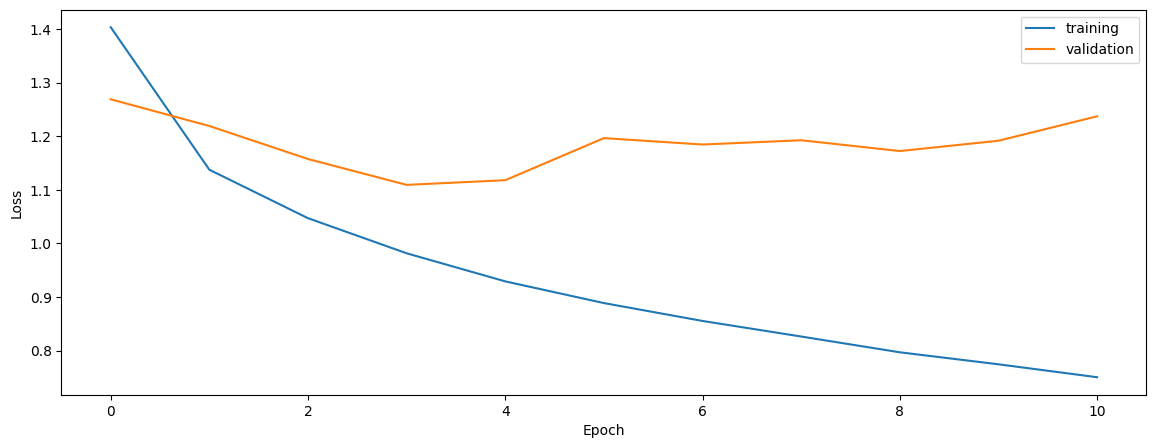

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6418908759457128
0.5485448473282443
0.6404348917143204


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

normalized


0.49728290218104226
0.4520011642447926
0.4419189540492368


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.4936111977223954
0.46370733327877556
0.43815180448987023


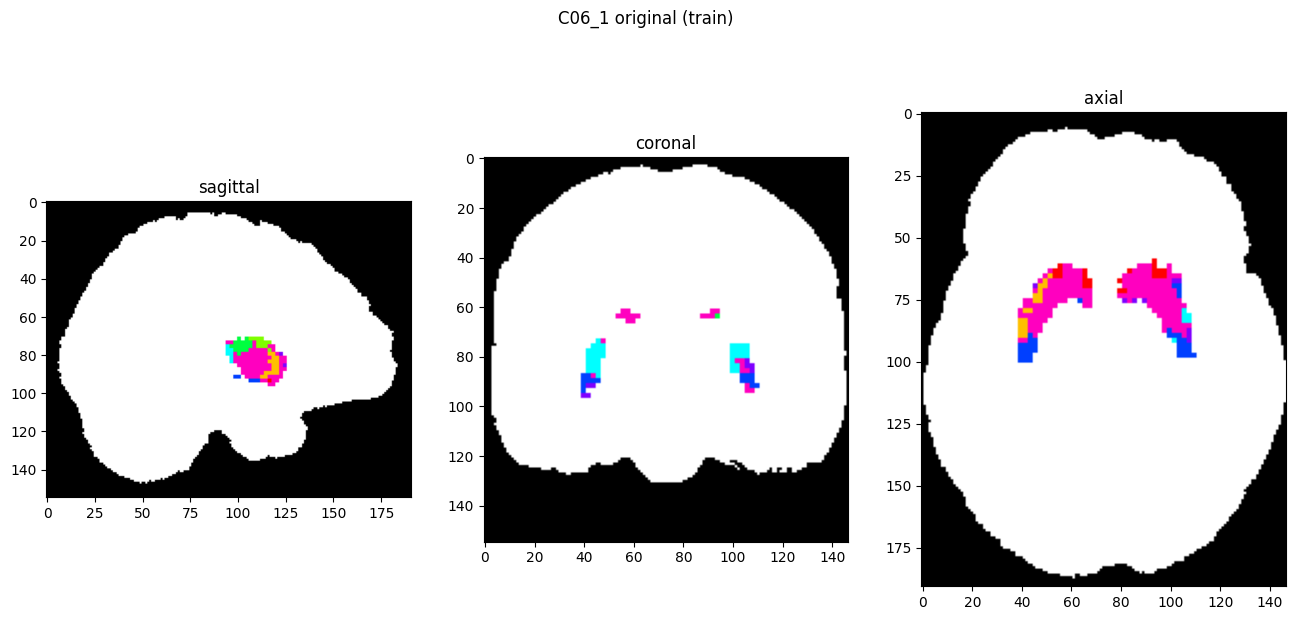

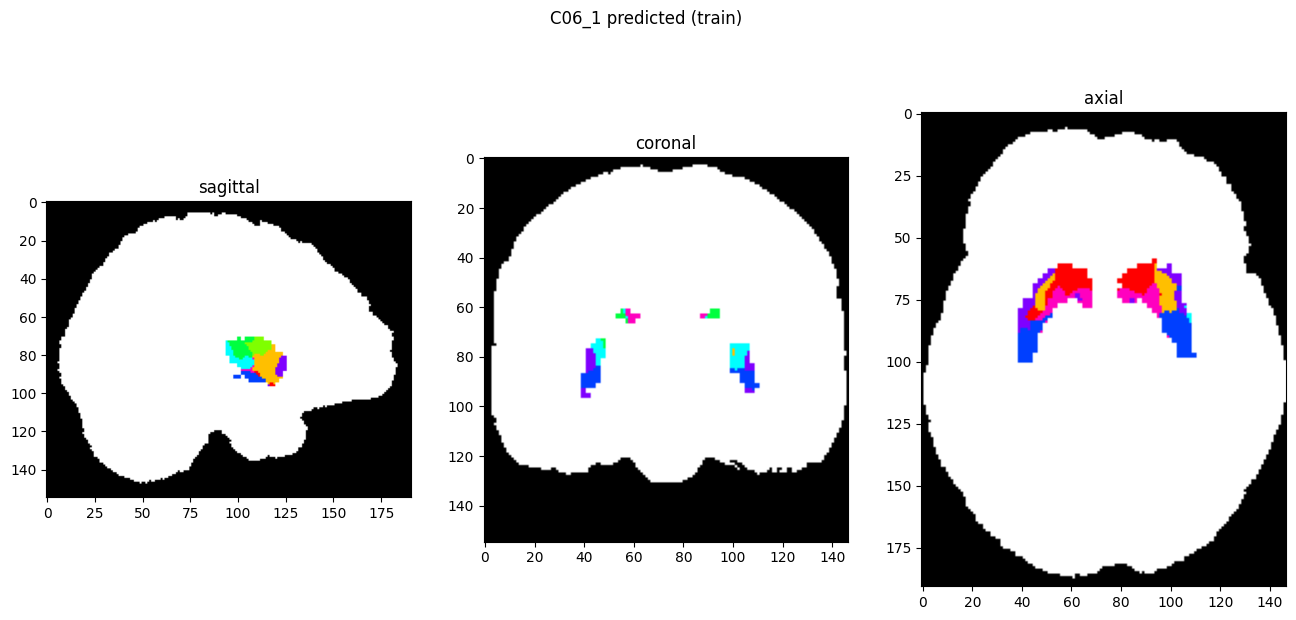

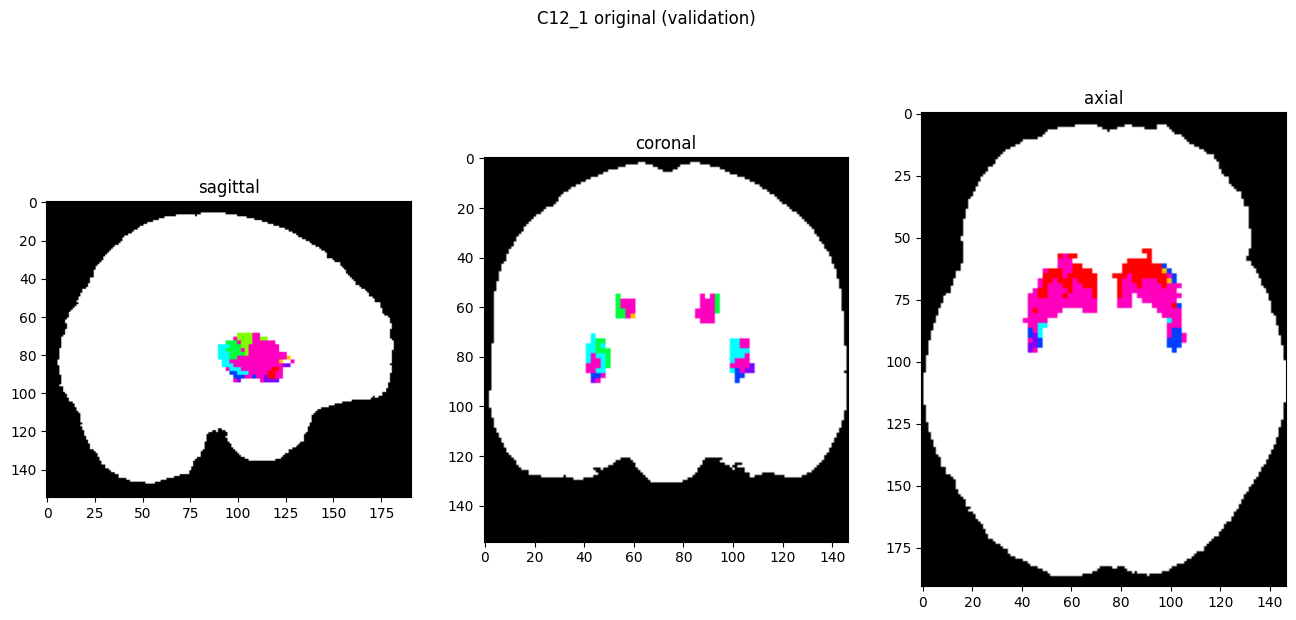

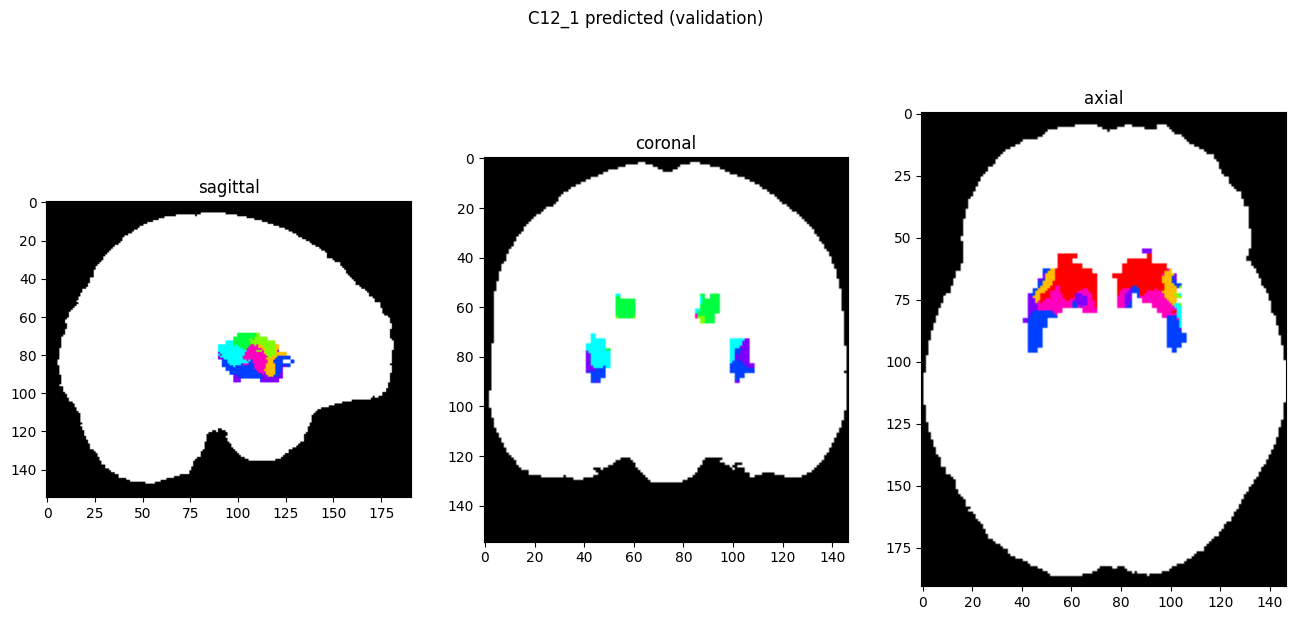

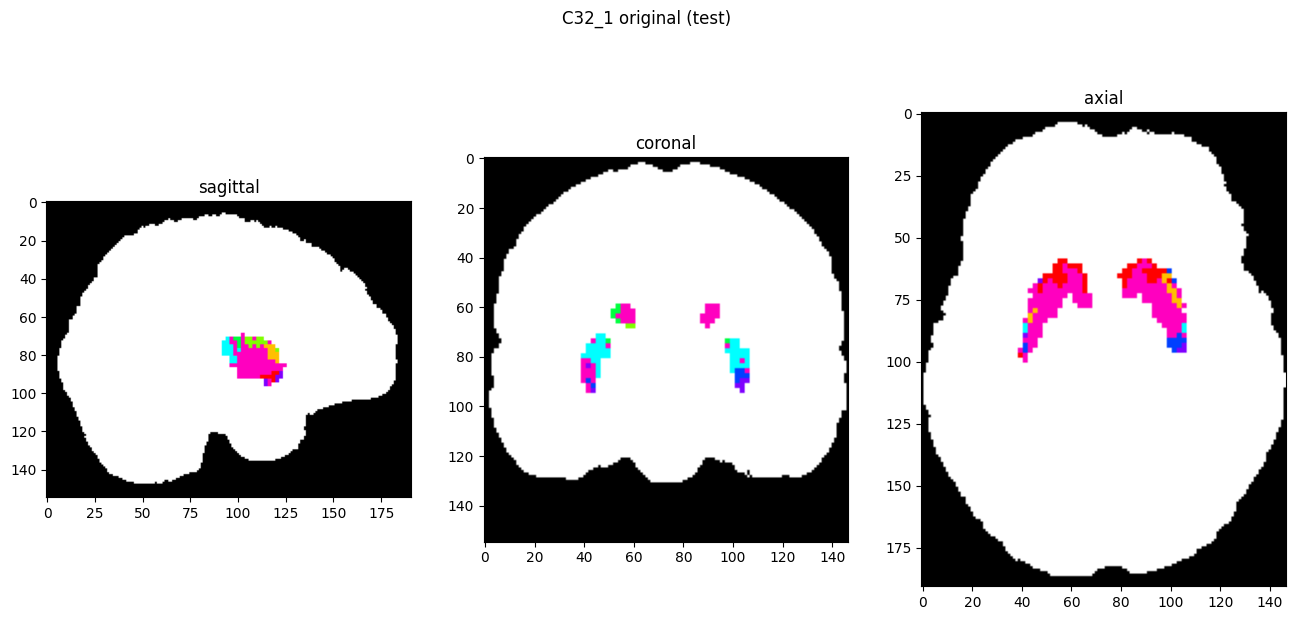

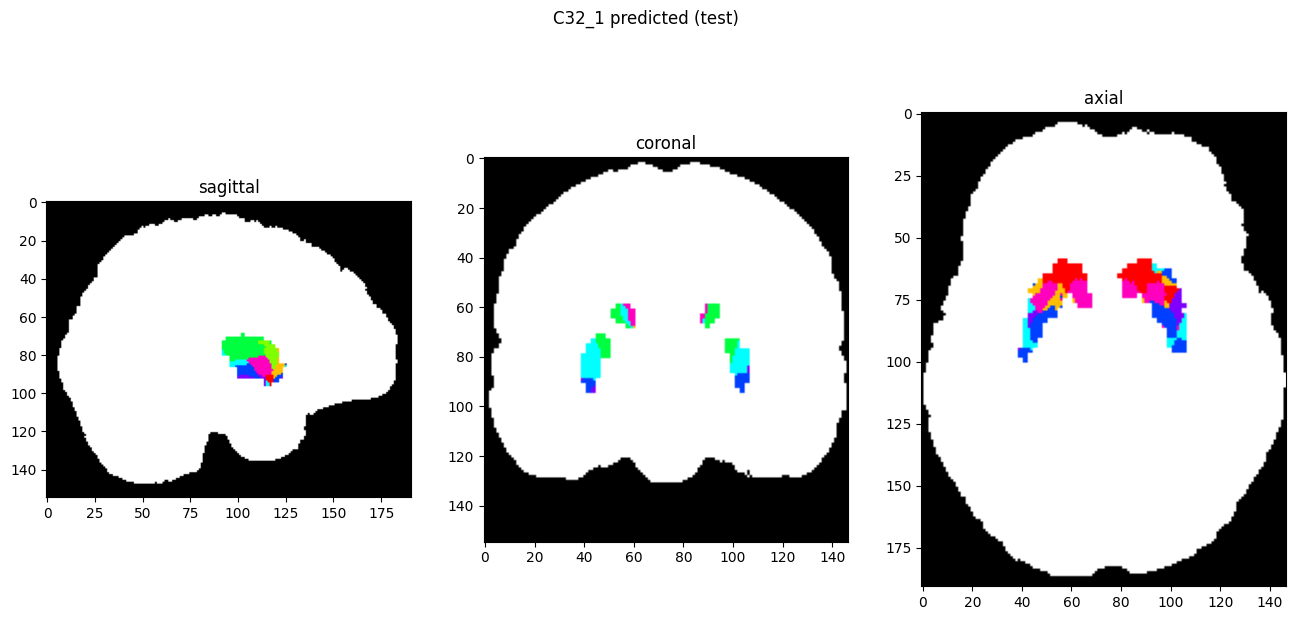

In [10]:
showResults(model, gen, threshold=0)